### Importe de librerias 


In [1]:
#Para poner la barra de progreso durante el entrenamiento 
!pip install tqdm
import sys
!"{sys.executable}" -m pip install tqdm 

In [2]:
import pennylane as qml
import numpy as np
from pennylane import numpy as pnp
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import random
import pickle
from scipy.stats import truncnorm
import math

### Definición del dispositivo y número de qubits

Un dispositivo cuántico es un objeto que representa el backend donde se ejecuta el circuito cuántico.

qml.device carga un dispositivo cuántico particular.

'default.qubit':un simulador de estados puros.

'default.mixed':un simulador de estados mezclados.

In [3]:
#Definición del dispositivo cuántico
dev = qml.device("default.mixed", wires=4)

### Arquitectura del Circuito 


Un QNode es una función que contiene al circuito variacional y el dispositivo computacional en el que se ejecuta.

interface="autograd": le dice a PennyLane que los parámetros serán diferenciables con autograd (la librería automática de derivación).

qml.QubitDensityMatrix requiere el estado total del sistema completo.

Toma el estado base (qubits 0 y 1 en |00⟩⟨00|) y lo combina con el estado rho (en qubits 2 y 3) para formar el estado de los 4 qubits juntos.


In [4]:

@qml.qnode(dev) #Decorador para definir el circuito cuántico
def Circuit(params, rho):
    # Crear estado |00⟩⟨00| para qubits 0 y 1
    base = pnp.zeros((4,4), dtype=complex)
    base[0,0] = 1.0 # Para poner la primera entrada de la matriz en 1 y el resto en 0
    
    # Producto tensorial para obtener estado total de 4 qubits
    full_state = pnp.kron(base, rho)
    
    # Usar en el dispositivo de 4 qubits
    qml.QubitDensityMatrix(full_state, wires=[0, 1, 2, 3])
    
    qml.Rot(params[0], params[1], params[2], wires=0)
    qml.Rot(params[3], params[4], params[5], wires=1)
    qml.Rot(params[6], params[7], params[8], wires=2)
    qml.Rot(params[9], params[10], params[11], wires=3)
    
    qml.CNOT(wires=[0, 1])
    qml.CNOT(wires=[0, 2])
    qml.CNOT(wires=[0, 3])
    qml.CNOT(wires=[3, 0])

    # La compuerta v1 opera si el qubit de control (0) está en |1⟩


    qml.PauliX(wires=0)

    qml.ctrl(qml.Rot(params[12], params[13], params[14], wires=1), control=0)
    qml.ctrl(qml.Rot(params[15], params[16], params[17], wires=2), control=0)
    qml.ctrl(qml.Rot(params[18], params[19], params[20], wires=3), control=0)
        
    
    qml.ctrl(qml.CNOT(wires=[1, 2]), control=0)
    qml.ctrl(qml.CNOT(wires=[1, 3]), control=0)
    qml.ctrl(qml.CNOT(wires=[3, 1]), control=0)

    qml.PauliX(wires=0)

    # La compuerta v2 opera si el qubit de control (0) está en |0⟩


    qml.ctrl(qml.Rot(params[21], params[22], params[23], wires=1), control=0)
    qml.ctrl(qml.Rot(params[24], params[25], params[26], wires=2), control=0)
    qml.ctrl(qml.Rot(params[27], params[28], params[29], wires=3), control=0)
        
    
    qml.ctrl(qml.CNOT(wires=[1, 2]), control=0)
    qml.ctrl(qml.CNOT(wires=[1, 3]), control=0)
    qml.ctrl(qml.CNOT(wires=[3, 1]), control=0)    
    
    return qml.probs(wires=[0, 1]) 



### Definición de las familias 

dtype= complex porque aunque las matrices se definan para parametros a y b reales, 
la evolución del sistema si puede introducir números complejos.

In [5]:
def ρ1(a):
    
    psi1 = pnp.array([np.sqrt(1 - a*a), 0.0, a, 0.0], dtype=complex)
    rho1 = pnp.outer(psi1, psi1.conj())
    return rho1, 1

def ρ2(b):

    psi2 = pnp.array([0.0, np.sqrt(1 - b*b), b, 0.0], dtype=complex)
    psi3 = pnp.array([0.0, -np.sqrt(1 - b*b), b, 0.0], dtype=complex)
    rho2 = 0.5 * np.outer(psi2, psi2.conj()) + 0.5 * np.outer(psi3, psi3.conj())

    return rho2, 2
    

### Conjunto de Datos de Prueba 

Para el caso de la distribución uniforme

In [6]:
np.random.seed(2)
n_test = 10000
data_test = []

def sample_truncated_normal(mean, std, size):
    a, b = (0 - mean) / std, (1 - mean) / std
    return truncnorm(a, b, loc=mean, scale=std).rvs(size)

a_values = sample_truncated_normal(mean=0.25, std=0.05, size=n_test//3)

for a in a_values:
    rho, label = ρ1(a)
    data_test.append((rho, label))

b_test = np.random.uniform(0, 1, math.ceil(n_test*(2/3)))
for b in b_test:
    rho, label = ρ2(b)
    data_test.append((rho, label))

### Conjunto de Datos de Entrenamiento 


In [7]:
np.random.seed(90701)
n_samples = 600
data = []

def sample_truncated_normal(mean, std, size):
    a, b = (0 - mean) / std, (1 - mean) / std
    return truncnorm(a, b, loc=mean, scale=std).rvs(size)

a_values = sample_truncated_normal(mean=0.25, std=0.05, size=n_samples//3)
for a in a_values:
    rho, label = ρ1(a)
    data.append((rho, label))  


b_values = np.random.uniform(0, 1, math.ceil(n_samples*(2/3)))
for b in b_values:
    rho, label = ρ2(b)
    data.append((rho, label))

data_train, data_val = train_test_split(data, test_size=0.2, random_state=42)

### Función de Pérdida 


In [8]:
# Funciones de pérdida

# Clasificación mínimo error (Probabilidad de inconclusión casi nula)

alpha_err = 10  # penaliza los errores
alpha_inc = 2 # penaliza los resultados inconclusos


# Función de pérdida para una muestra según el label:
# label 1: familia 1 se espera que los outcomes 00 y 10 sean correctos.
# label 2: familia 2 se espera que el outcome 01 sea correcto.

def sample_loss(params, rho, label):
    
    probs = Circuit(params, rho)
    # |00> -> probs[0], |01> -> probs[1], |10> -> probs[2], |11> -> probs[3]
    if label == 1:
        # Familia 1 => éxito: (|00>, |10>), error: |01>, inconcluso: |11>
        p_suc = (probs[0] + probs[2])
        p_err = probs[1]
        p_inc = probs[3]
    else:
        # Familia 2 => éxito: |01>, error: (|00>, |10>), inconcluso: |11>
        p_suc = probs[1]
        p_err = probs[0] + probs[2]
        p_inc = probs[3]
        
    return (
    pnp.abs(p_suc - 1.0)
    + alpha_err * pnp.abs(p_err - 0.0)
    + alpha_inc * pnp.abs(p_inc - 0.0)
    )

# Función global de pérdida que promedia sobre el conjunto de muestras

def loss(params, samples):
    total = pnp.array(0.0, requires_grad=True) #iniciar el acumulador del costo total,
    #asegurar que ese acumulador soporta derivación automática, y permitir que luego PennyLane optimice los parámetros con gradientes.  

    for (rho, label) in samples:
        total = total + sample_loss(params, rho, label)

    avg = total / len(samples)           
    return avg  

In [9]:
def get_probabilities(params, rho, label):
    """Calcula las probabilidades de salida del circuito, dada la matriz de densidad."""
    
    return Circuit(params, rho)


### Evaluación del modelo

In [10]:
def evaluate_model(params, samples):
    """Evalúa tasas promedio de éxito, error e inconcluso en cada familia."""
    
    # Separar por familia
    S1 = [rho for (rho, label) in samples if label == 1]
    S2 = [rho for (rho, label) in samples if label == 2]

    total_suc_1, total_err_1, total_inc_1 = 0, 0, 0
    total_suc_2, total_err_2, total_inc_2 = 0, 0, 0

    for rho in S1:
        probs = get_probabilities(params, rho, 1)
        total_suc_1 += probs[0] + probs[2]  # éxito
        total_err_1 += probs[1]
        total_inc_1 += probs[3]

    for rho in S2:
        probs = get_probabilities(params, rho, 2)
        total_suc_2 += probs[1]             # éxito
        total_err_2 += probs[0] + probs[2]
        total_inc_2 += probs[3]

    # Promedios por familia
    n1, n2 = len(S1), len(S2)
    suc = (total_suc_1 + total_suc_2) / (n1 + n2)
    err = (total_err_1 + total_err_2) / (n1 + n2)
    inc = (total_inc_1 + total_inc_2) / (n1 + n2)

    return suc, err, inc


In [11]:
def get_batches(data, batch_size):
    # Asegurar que batch_size sea al menos 1
    batch_size = max(1, int(batch_size))
    
    # Mezclar los datos
    data_shuffled = random.sample(data, len(data))
    
    # Crear los lotes
    return [data_shuffled[i:i+batch_size] for i in range(0, len(data), batch_size)]


### Entrenamiento del modelo


params, curr_loss = opt.step_and_cost(lambda v: loss(v, data_train), params)

opt: Optimizador
.step_and_cost(...): Método que actualiza los parámetros y devuelve el valor de la función de costo


Calcula el valor de la función de la función de costo (loss(...)) para los parámetros actuales.
Calcula el gradiente de esa función de costo con respecto a los parámetros.
Actualiza los parámetros en la dirección que reduce la función de costo.

Devuelve:

params: los nuevos parámetros después de actualizar.

curr_loss: el valor actual de la función de costo.

La función lambda hace que el optimizador calcule la función de costo con los parámetros v usando el conjunto de datos data_train que ya está fijado.



In [12]:
opt = qml.AdamOptimizer(stepsize=0.01)
n_iter = 5000
batch_size = int(len(data_train) * 0.2)
val_batch_size = int(0.2 * batch_size)

initial_params = np.random.uniform(0, 2 * np.pi, 30)
params = pnp.array(initial_params, requires_grad=True)

# Early stopping
patience = 500
min_delta = 1e-4
best_val_loss = float('inf')
patience_counter = 0
best_params = params.copy()  # Guardar los mejores parámetros

# ReduceLROnPlateau
plateau_patience = 150
plateau_factor = 0.5
min_lr = 1e-5
plateau_counter = 0

# Historiales
loss_history = []
val_loss_history = []
train_suc_history = []
train_err_history = []
train_inc_history = []
val_suc_history = []
val_err_history = []
val_inc_history = []

for it in tqdm(range(n_iter), desc="Entrenando"):

    # Batch aleatorio
    batch = random.sample(data_train, batch_size)

    # Paso de entrenamiento
    params, train_loss = opt.step_and_cost(lambda v: loss(v, batch), params)

    # Evaluación en validación
    val_batches = get_batches(data_val, val_batch_size)
    val_loss = 0
    for vb in val_batches:
        val_loss += loss(params, vb) * len(vb)
    val_loss /= len(data_val)

    # EARLY STOPPING 
    if val_loss < best_val_loss - min_delta:  # Mejora significativa
        best_val_loss = val_loss
        best_params = params.copy()  # Guardar mejores parámetros
        patience_counter = 0
        plateau_counter = 0  # reinicia ambos contadores
    else:
        patience_counter += 1
        plateau_counter += 1

    # REDUCE LR ON PLATEAU 
    if plateau_counter >= plateau_patience:
        new_lr = max(opt.stepsize * plateau_factor, min_lr)
        if new_lr < opt.stepsize:
            print(f"Reducción de learning rate: {opt.stepsize:.5f} → {new_lr:.5f}")
            opt.stepsize = new_lr
            plateau_counter = 0  # Reiniciar después de reducir LR

    # STOPPING 
    if patience_counter >= patience:
        print(f"Early stopping en iteración {it+1}. Mejor pérdida de validación: {best_val_loss:.6f}")
        params = best_params  # Restaurar mejores parámetros
        break

    # Evaluación en train, test y validación
    suc_train, err_train, inc_train = evaluate_model(params, data_train)
    suc_val, err_val, inc_val = evaluate_model(params, data_val)


    # Guardar métricas
    loss_history.append(train_loss)
    val_loss_history.append(val_loss)
    train_suc_history.append(suc_train)
    train_err_history.append(err_train)
    train_inc_history.append(inc_train)
    val_suc_history.append(suc_val)
    val_err_history.append(err_val)
    val_inc_history.append(inc_val)

    if (it + 1) % 50 == 0:
        print(f"Iter {it+1:3d}: train_loss={train_loss:.4f}, val_loss={val_loss:.4f}, "
              f"train_suc={suc_train:.3f}, train_err={err_train:.3f}, train_inc={inc_train:.3f} | "
              f"val_suc={suc_val:.3f}, val_err={err_val:.3f}, val_inc={inc_val:.3f}") 
    if (it + 1) % 100 == 0:
        print(f"Iter {it+1}: LR actual = {opt.stepsize:.6f}")

# Usar los mejores parámetros al final
params = best_params

# Final
print("\nParámetros entrenados:")
print(params)

print("\nResultados finales en el conjunto de prueba:")
test_suc, test_err, test_inc = evaluate_model(params, data_test)
print(f"  Éxito promedio     = {test_suc:.4f}")
print(f"  Error promedio     = {test_err:.4f}")
print(f"  Inconcluso promedio = {test_inc:.4f}")




Entrenando:   0%|          | 0/5000 [00:00<?, ?it/s]

Entrenando:   0%|          | 1/5000 [01:49<151:22:22, 109.01s/it]

Entrenando:   0%|          | 2/5000 [03:34<148:52:19, 107.23s/it]

Entrenando:   0%|          | 3/5000 [05:21<148:26:23, 106.94s/it]

Entrenando:   0%|          | 4/5000 [07:10<149:22:13, 107.63s/it]

Entrenando:   0%|          | 5/5000 [09:09<155:04:01, 111.76s/it]

Entrenando:   0%|          | 6/5000 [11:01<155:05:06, 111.80s/it]

Entrenando:   0%|          | 7/5000 [12:58<157:44:59, 113.74s/it]

Entrenando:   0%|          | 8/5000 [15:29<174:03:15, 125.52s/it]

Entrenando:   0%|          | 9/5000 [17:52<181:35:37, 130.98s/it]

Entrenando:   0%|          | 10/5000 [20:08<183:36:30, 132.46s/it]

Entrenando:   0%|          | 11/5000 [22:24<184:52:42, 133.41s/it]

Entrenando:   0%|          | 12/5000 [24:39<185:31:55, 133.90s/it]

Entrenando:   0%|          | 13/5000 [26:54<185:57:14, 134.24s/it]

Entrenando:   0%|          | 14/5000 [29:09<186:29:58, 134.66s/it]

Entrenando:   0%|          | 15/5000 [31:26<187:14:10, 135.22s/it]

Entrenando:   0%|          | 16/5000 [33:40<186:39:51, 134.83s/it]

Entrenando:   0%|          | 17/5000 [35:55<186:46:54, 134.94s/it]

Entrenando:   0%|          | 18/5000 [38:12<187:29:31, 135.48s/it]

Entrenando:   0%|          | 19/5000 [40:29<188:05:51, 135.95s/it]

Entrenando:   0%|          | 20/5000 [42:44<187:43:58, 135.71s/it]

Entrenando:   0%|          | 21/5000 [45:11<192:17:49, 139.04s/it]

Entrenando:   0%|          | 22/5000 [47:40<196:42:20, 142.25s/it]

Entrenando:   0%|          | 23/5000 [50:01<195:57:24, 141.74s/it]

Entrenando:   0%|          | 24/5000 [52:31<199:13:45, 144.14s/it]

Entrenando:   0%|          | 25/5000 [54:57<200:13:39, 144.89s/it]

Entrenando:   1%|          | 26/5000 [57:23<200:31:16, 145.13s/it]

Entrenando:   1%|          | 27/5000 [59:49<201:03:27, 145.55s/it]

Entrenando:   1%|          | 28/5000 [1:02:12<199:57:41, 144.78s/it]

Entrenando:   1%|          | 29/5000 [1:04:22<193:44:47, 140.31s/it]

Entrenando:   1%|          | 30/5000 [1:06:27<187:08:14, 135.55s/it]

Entrenando:   1%|          | 31/5000 [1:08:21<178:15:00, 129.14s/it]

Entrenando:   1%|          | 32/5000 [1:10:24<175:44:24, 127.35s/it]

Entrenando:   1%|          | 33/5000 [1:12:23<172:05:53, 124.73s/it]

Entrenando:   1%|          | 34/5000 [1:14:17<167:35:39, 121.49s/it]

Entrenando:   1%|          | 35/5000 [1:16:09<163:51:57, 118.82s/it]

Entrenando:   1%|          | 36/5000 [1:17:55<158:21:17, 114.84s/it]

Entrenando:   1%|          | 37/5000 [1:19:38<153:32:47, 111.38s/it]

Entrenando:   1%|          | 38/5000 [1:21:29<153:18:22, 111.23s/it]

Entrenando:   1%|          | 39/5000 [1:23:11<149:28:40, 108.47s/it]

Entrenando:   1%|          | 40/5000 [1:24:53<146:38:49, 106.44s/it]

Entrenando:   1%|          | 41/5000 [1:26:49<150:42:27, 109.41s/it]

Entrenando:   1%|          | 42/5000 [1:28:31<147:25:34, 107.05s/it]

Entrenando:   1%|          | 43/5000 [1:30:08<143:25:10, 104.16s/it]

Entrenando:   1%|          | 44/5000 [1:31:49<141:52:46, 103.06s/it]

Entrenando:   1%|          | 45/5000 [1:33:37<144:05:30, 104.69s/it]

Entrenando:   1%|          | 46/5000 [1:35:14<140:58:56, 102.45s/it]

Entrenando:   1%|          | 47/5000 [1:36:56<140:35:12, 102.18s/it]

Entrenando:   1%|          | 48/5000 [1:38:50<145:40:11, 105.90s/it]

Entrenando:   1%|          | 49/5000 [1:40:38<146:25:23, 106.47s/it]

Entrenando:   1%|          | 50/5000 [1:42:17<143:05:22, 104.07s/it]

Iter  50: train_loss=3.4750, val_loss=3.2822, train_suc=0.357, train_err=0.178, train_inc=0.465 | val_suc=0.375, val_err=0.176, val_inc=0.448


Entrenando:   1%|          | 51/5000 [1:44:07<145:33:54, 105.89s/it]

Entrenando:   1%|          | 52/5000 [1:46:00<148:36:07, 108.12s/it]

Entrenando:   1%|          | 53/5000 [1:47:37<143:59:20, 104.78s/it]

Entrenando:   1%|          | 54/5000 [1:49:13<140:25:23, 102.21s/it]

Entrenando:   1%|          | 55/5000 [1:50:50<138:19:33, 100.70s/it]

Entrenando:   1%|          | 56/5000 [1:52:26<136:07:06, 99.12s/it] 

Entrenando:   1%|          | 57/5000 [1:53:58<133:01:03, 96.88s/it]

Entrenando:   1%|          | 58/5000 [1:55:33<132:12:51, 96.31s/it]

Entrenando:   1%|          | 59/5000 [1:57:06<130:57:58, 95.42s/it]

Entrenando:   1%|          | 60/5000 [1:58:39<129:54:11, 94.67s/it]

Entrenando:   1%|          | 61/5000 [2:00:13<129:40:50, 94.52s/it]

Entrenando:   1%|          | 62/5000 [2:01:45<128:37:31, 93.77s/it]

Entrenando:   1%|▏         | 63/5000 [2:03:15<127:03:16, 92.65s/it]

Entrenando:   1%|▏         | 64/5000 [2:04:39<123:31:56, 90.10s/it]

Entrenando:   1%|▏         | 65/5000 [2:06:02<120:36:32, 87.98s/it]

Entrenando:   1%|▏         | 66/5000 [2:07:25<118:30:43, 86.47s/it]

Entrenando:   1%|▏         | 67/5000 [2:08:46<116:09:58, 84.78s/it]

Entrenando:   1%|▏         | 68/5000 [2:10:07<114:32:17, 83.60s/it]

Entrenando:   1%|▏         | 69/5000 [2:11:24<112:00:25, 81.77s/it]

Entrenando:   1%|▏         | 70/5000 [2:12:40<109:35:05, 80.02s/it]

Entrenando:   1%|▏         | 71/5000 [2:14:01<109:39:23, 80.09s/it]

Entrenando:   1%|▏         | 72/5000 [2:15:14<106:59:08, 78.16s/it]

Entrenando:   1%|▏         | 73/5000 [2:16:20<101:57:41, 74.50s/it]

Entrenando:   1%|▏         | 74/5000 [2:17:31<100:25:19, 73.39s/it]

Entrenando:   2%|▏         | 75/5000 [2:18:40<98:44:49, 72.18s/it] 

Entrenando:   2%|▏         | 76/5000 [2:19:56<100:21:44, 73.38s/it]

Entrenando:   2%|▏         | 77/5000 [2:21:09<100:06:03, 73.20s/it]

Entrenando:   2%|▏         | 78/5000 [2:22:23<100:27:34, 73.48s/it]

Entrenando:   2%|▏         | 79/5000 [2:23:43<102:57:20, 75.32s/it]

Entrenando:   2%|▏         | 80/5000 [2:24:57<102:14:53, 74.82s/it]

Entrenando:   2%|▏         | 81/5000 [2:26:06<99:53:25, 73.11s/it] 

Entrenando:   2%|▏         | 82/5000 [2:27:21<100:34:50, 73.63s/it]

Entrenando:   2%|▏         | 83/5000 [2:28:31<99:03:37, 72.53s/it] 

Entrenando:   2%|▏         | 84/5000 [2:29:43<99:04:59, 72.56s/it]

Entrenando:   2%|▏         | 85/5000 [2:30:56<99:19:39, 72.75s/it]

Entrenando:   2%|▏         | 86/5000 [2:32:12<100:33:18, 73.67s/it]

Entrenando:   2%|▏         | 87/5000 [2:33:29<101:59:47, 74.74s/it]

Entrenando:   2%|▏         | 88/5000 [2:34:37<99:03:04, 72.59s/it] 

Entrenando:   2%|▏         | 89/5000 [2:35:48<98:33:00, 72.24s/it]

Entrenando:   2%|▏         | 90/5000 [2:36:57<97:05:50, 71.19s/it]

Entrenando:   2%|▏         | 91/5000 [2:38:10<97:42:08, 71.65s/it]

Entrenando:   2%|▏         | 92/5000 [2:39:19<96:45:38, 70.97s/it]

Entrenando:   2%|▏         | 93/5000 [2:40:24<94:16:37, 69.17s/it]

Entrenando:   2%|▏         | 94/5000 [2:41:35<94:59:38, 69.71s/it]

Entrenando:   2%|▏         | 95/5000 [2:42:52<97:50:01, 71.80s/it]

Entrenando:   2%|▏         | 96/5000 [2:44:07<98:59:47, 72.67s/it]

Entrenando:   2%|▏         | 97/5000 [2:45:16<97:36:41, 71.67s/it]

Entrenando:   2%|▏         | 98/5000 [2:46:30<98:41:54, 72.48s/it]

Entrenando:   2%|▏         | 99/5000 [2:47:36<95:57:32, 70.49s/it]

Entrenando:   2%|▏         | 100/5000 [2:48:54<98:50:39, 72.62s/it]

Iter 100: train_loss=2.0669, val_loss=1.9973, train_suc=0.414, train_err=0.036, train_inc=0.551 | val_suc=0.432, val_err=0.037, val_inc=0.531
Iter 100: LR actual = 0.010000


Entrenando:   2%|▏         | 101/5000 [2:50:04<98:00:11, 72.02s/it]

Entrenando:   2%|▏         | 102/5000 [2:51:23<100:37:15, 73.96s/it]

Entrenando:   2%|▏         | 103/5000 [2:52:38<101:08:04, 74.35s/it]

Entrenando:   2%|▏         | 104/5000 [2:53:50<100:15:29, 73.72s/it]

Entrenando:   2%|▏         | 105/5000 [2:54:57<97:23:48, 71.63s/it] 

Entrenando:   2%|▏         | 106/5000 [2:56:14<99:29:09, 73.18s/it]

Entrenando:   2%|▏         | 107/5000 [2:57:29<100:17:02, 73.78s/it]

Entrenando:   2%|▏         | 108/5000 [2:58:47<101:57:20, 75.03s/it]

Entrenando:   2%|▏         | 109/5000 [2:59:57<99:47:24, 73.45s/it] 

Entrenando:   2%|▏         | 110/5000 [3:01:14<101:11:58, 74.50s/it]

Entrenando:   2%|▏         | 111/5000 [3:02:17<96:47:27, 71.27s/it] 

Entrenando:   2%|▏         | 112/5000 [3:03:36<99:45:05, 73.47s/it]

Entrenando:   2%|▏         | 113/5000 [3:04:55<102:03:46, 75.18s/it]

Entrenando:   2%|▏         | 114/5000 [3:06:04<99:29:57, 73.31s/it] 

Entrenando:   2%|▏         | 115/5000 [3:07:16<98:55:21, 72.90s/it]

Entrenando:   2%|▏         | 116/5000 [3:08:34<101:04:55, 74.51s/it]

Entrenando:   2%|▏         | 117/5000 [3:09:44<99:12:03, 73.14s/it] 

Entrenando:   2%|▏         | 118/5000 [3:10:55<97:59:09, 72.26s/it]

Entrenando:   2%|▏         | 119/5000 [3:12:09<98:57:29, 72.99s/it]

Entrenando:   2%|▏         | 120/5000 [3:13:20<97:56:08, 72.25s/it]

Entrenando:   2%|▏         | 121/5000 [3:14:33<98:20:23, 72.56s/it]

Entrenando:   2%|▏         | 122/5000 [3:15:45<98:12:06, 72.47s/it]

Entrenando:   2%|▏         | 123/5000 [3:16:57<97:55:39, 72.29s/it]

Entrenando:   2%|▏         | 124/5000 [3:18:07<96:55:37, 71.56s/it]

Entrenando:   2%|▎         | 125/5000 [3:19:17<96:05:49, 70.96s/it]

Entrenando:   3%|▎         | 126/5000 [3:20:33<98:08:11, 72.48s/it]

Entrenando:   3%|▎         | 127/5000 [3:21:49<99:47:10, 73.72s/it]

Entrenando:   3%|▎         | 128/5000 [3:23:02<99:18:25, 73.38s/it]

Entrenando:   3%|▎         | 129/5000 [3:24:17<100:05:12, 73.97s/it]

Entrenando:   3%|▎         | 130/5000 [3:25:30<99:41:29, 73.69s/it] 

Entrenando:   3%|▎         | 131/5000 [3:26:48<101:15:23, 74.87s/it]

Entrenando:   3%|▎         | 132/5000 [3:28:06<102:40:39, 75.93s/it]

Entrenando:   3%|▎         | 133/5000 [3:29:16<100:17:28, 74.18s/it]

Entrenando:   3%|▎         | 134/5000 [3:30:36<102:27:45, 75.80s/it]

Entrenando:   3%|▎         | 135/5000 [3:31:58<105:10:21, 77.83s/it]

Entrenando:   3%|▎         | 136/5000 [3:33:11<102:53:48, 76.16s/it]

Entrenando:   3%|▎         | 137/5000 [3:34:18<99:07:34, 73.38s/it] 

Entrenando:   3%|▎         | 138/5000 [3:35:37<101:27:58, 75.13s/it]

Entrenando:   3%|▎         | 139/5000 [3:36:49<100:24:18, 74.36s/it]

Entrenando:   3%|▎         | 140/5000 [3:38:06<101:10:34, 74.95s/it]

Entrenando:   3%|▎         | 141/5000 [3:39:09<96:23:52, 71.42s/it] 

Entrenando:   3%|▎         | 142/5000 [3:40:17<94:52:35, 70.31s/it]

Entrenando:   3%|▎         | 143/5000 [3:41:32<96:59:56, 71.90s/it]

Entrenando:   3%|▎         | 144/5000 [3:42:44<97:06:59, 72.00s/it]

Entrenando:   3%|▎         | 145/5000 [3:43:50<94:35:29, 70.14s/it]

Entrenando:   3%|▎         | 146/5000 [3:45:00<94:13:35, 69.88s/it]

Entrenando:   3%|▎         | 147/5000 [3:46:21<98:41:56, 73.22s/it]

Entrenando:   3%|▎         | 148/5000 [3:47:33<98:20:06, 72.96s/it]

Entrenando:   3%|▎         | 149/5000 [3:48:50<99:50:28, 74.09s/it]

Entrenando:   3%|▎         | 150/5000 [3:49:57<97:14:30, 72.18s/it]

Iter 150: train_loss=1.7237, val_loss=1.6513, train_suc=0.442, train_err=0.005, train_inc=0.553 | val_suc=0.462, val_err=0.005, val_inc=0.533


Entrenando:   3%|▎         | 151/5000 [3:51:12<98:16:43, 72.96s/it]

Entrenando:   3%|▎         | 152/5000 [3:52:25<98:24:10, 73.07s/it]

Entrenando:   3%|▎         | 153/5000 [3:53:37<97:48:20, 72.64s/it]

Entrenando:   3%|▎         | 154/5000 [3:54:51<98:28:00, 73.15s/it]

Entrenando:   3%|▎         | 155/5000 [3:56:06<98:51:19, 73.45s/it]

Entrenando:   3%|▎         | 156/5000 [3:57:23<100:17:32, 74.54s/it]

Entrenando:   3%|▎         | 157/5000 [3:58:32<98:20:06, 73.10s/it] 

Entrenando:   3%|▎         | 158/5000 [3:59:50<100:10:45, 74.48s/it]

Entrenando:   3%|▎         | 159/5000 [4:01:01<98:47:03, 73.46s/it] 

Entrenando:   3%|▎         | 160/5000 [4:02:10<96:42:51, 71.94s/it]

Entrenando:   3%|▎         | 161/5000 [4:03:25<98:13:59, 73.08s/it]

Entrenando:   3%|▎         | 162/5000 [4:04:39<98:34:03, 73.35s/it]

Entrenando:   3%|▎         | 163/5000 [4:05:58<100:40:12, 74.93s/it]

Entrenando:   3%|▎         | 164/5000 [4:07:14<101:03:30, 75.23s/it]

Entrenando:   3%|▎         | 165/5000 [4:08:23<98:41:09, 73.48s/it] 

Entrenando:   3%|▎         | 166/5000 [4:09:37<98:40:11, 73.48s/it]

Entrenando:   3%|▎         | 167/5000 [4:10:54<99:58:51, 74.47s/it]

Entrenando:   3%|▎         | 168/5000 [4:12:11<101:00:23, 75.25s/it]

Entrenando:   3%|▎         | 169/5000 [4:13:23<99:50:55, 74.41s/it] 

Entrenando:   3%|▎         | 170/5000 [4:14:39<100:21:48, 74.81s/it]

Entrenando:   3%|▎         | 171/5000 [4:15:46<97:26:42, 72.64s/it] 

Entrenando:   3%|▎         | 172/5000 [4:17:05<99:44:33, 74.37s/it]

Entrenando:   3%|▎         | 173/5000 [4:18:20<99:58:09, 74.56s/it]

Entrenando:   3%|▎         | 174/5000 [4:19:31<98:40:27, 73.61s/it]

Entrenando:   4%|▎         | 175/5000 [4:20:46<99:12:32, 74.02s/it]

Entrenando:   4%|▎         | 176/5000 [4:21:56<97:31:26, 72.78s/it]

Entrenando:   4%|▎         | 177/5000 [4:23:09<97:37:36, 72.87s/it]

Entrenando:   4%|▎         | 178/5000 [4:24:25<99:00:15, 73.91s/it]

Entrenando:   4%|▎         | 179/5000 [4:25:38<98:26:40, 73.51s/it]

Entrenando:   4%|▎         | 180/5000 [4:26:51<98:10:55, 73.33s/it]

Entrenando:   4%|▎         | 181/5000 [4:27:56<94:52:49, 70.88s/it]

Entrenando:   4%|▎         | 182/5000 [4:29:09<95:50:55, 71.62s/it]

Entrenando:   4%|▎         | 183/5000 [4:30:34<101:02:30, 75.51s/it]

Entrenando:   4%|▎         | 184/5000 [4:32:32<118:09:04, 88.32s/it]

Entrenando:   4%|▎         | 185/5000 [4:34:48<137:00:43, 102.44s/it]

Entrenando:   4%|▎         | 186/5000 [4:36:56<147:27:30, 110.27s/it]

Entrenando:   4%|▎         | 187/5000 [4:39:06<155:16:18, 116.14s/it]

Entrenando:   4%|▍         | 188/5000 [4:41:13<159:32:59, 119.36s/it]

Entrenando:   4%|▍         | 189/5000 [4:43:19<162:02:29, 121.25s/it]

Entrenando:   4%|▍         | 190/5000 [4:45:25<164:06:44, 122.83s/it]

Entrenando:   4%|▍         | 191/5000 [4:47:30<164:57:42, 123.49s/it]

Entrenando:   4%|▍         | 192/5000 [4:49:39<166:56:45, 125.00s/it]

Entrenando:   4%|▍         | 193/5000 [4:51:46<167:50:40, 125.70s/it]

Entrenando:   4%|▍         | 194/5000 [4:53:45<165:14:24, 123.78s/it]

Entrenando:   4%|▍         | 195/5000 [4:55:49<165:04:17, 123.67s/it]

Entrenando:   4%|▍         | 196/5000 [4:57:51<164:17:50, 123.12s/it]

Entrenando:   4%|▍         | 197/5000 [4:59:50<162:49:05, 122.04s/it]

Entrenando:   4%|▍         | 198/5000 [5:01:54<163:35:15, 122.64s/it]

Entrenando:   4%|▍         | 199/5000 [5:03:56<163:06:04, 122.30s/it]

Entrenando:   4%|▍         | 200/5000 [5:06:05<165:46:22, 124.33s/it]

Iter 200: train_loss=1.6584, val_loss=1.5722, train_suc=0.462, train_err=0.003, train_inc=0.535 | val_suc=0.483, val_err=0.003, val_inc=0.514
Iter 200: LR actual = 0.010000


Entrenando:   4%|▍         | 201/5000 [5:08:17<169:03:01, 126.81s/it]

Entrenando:   4%|▍         | 202/5000 [5:10:26<169:57:47, 127.53s/it]

Entrenando:   4%|▍         | 203/5000 [5:12:33<169:38:33, 127.31s/it]

Entrenando:   4%|▍         | 204/5000 [5:14:42<170:20:19, 127.86s/it]

Entrenando:   4%|▍         | 205/5000 [5:16:58<173:23:07, 130.17s/it]

Entrenando:   4%|▍         | 206/5000 [5:19:15<176:04:31, 132.22s/it]

Entrenando:   4%|▍         | 207/5000 [5:21:23<174:27:59, 131.04s/it]

Entrenando:   4%|▍         | 208/5000 [5:23:29<172:10:32, 129.35s/it]

Entrenando:   4%|▍         | 209/5000 [5:25:35<170:57:53, 128.46s/it]

Entrenando:   4%|▍         | 210/5000 [5:27:46<171:54:08, 129.20s/it]

Entrenando:   4%|▍         | 211/5000 [5:29:57<172:44:59, 129.86s/it]

Entrenando:   4%|▍         | 212/5000 [5:32:05<171:40:14, 129.08s/it]

Entrenando:   4%|▍         | 213/5000 [5:34:20<174:10:44, 130.99s/it]

Entrenando:   4%|▍         | 214/5000 [5:36:36<176:06:27, 132.47s/it]

Entrenando:   4%|▍         | 215/5000 [5:38:44<174:14:03, 131.09s/it]

Entrenando:   4%|▍         | 216/5000 [5:40:49<172:01:40, 129.45s/it]

Entrenando:   4%|▍         | 217/5000 [5:43:05<174:32:23, 131.37s/it]

Entrenando:   4%|▍         | 218/5000 [5:45:06<170:14:36, 128.16s/it]

Entrenando:   4%|▍         | 219/5000 [5:47:01<164:50:41, 124.13s/it]

Entrenando:   4%|▍         | 220/5000 [5:49:01<163:08:07, 122.86s/it]

Entrenando:   4%|▍         | 221/5000 [5:50:57<160:32:46, 120.94s/it]

Entrenando:   4%|▍         | 222/5000 [5:52:52<158:09:00, 119.16s/it]

Entrenando:   4%|▍         | 223/5000 [5:54:40<153:36:27, 115.76s/it]

Entrenando:   4%|▍         | 224/5000 [5:56:16<145:45:54, 109.87s/it]

Entrenando:   4%|▍         | 225/5000 [5:57:57<142:06:02, 107.13s/it]

Entrenando:   5%|▍         | 226/5000 [5:59:30<136:36:28, 103.01s/it]

Entrenando:   5%|▍         | 227/5000 [6:01:04<133:06:18, 100.39s/it]

Entrenando:   5%|▍         | 228/5000 [6:02:52<135:44:39, 102.41s/it]

Entrenando:   5%|▍         | 229/5000 [6:04:42<138:57:06, 104.85s/it]

Entrenando:   5%|▍         | 230/5000 [6:06:34<141:52:22, 107.07s/it]

Entrenando:   5%|▍         | 231/5000 [6:08:25<143:13:42, 108.12s/it]

Entrenando:   5%|▍         | 232/5000 [6:10:12<142:57:45, 107.94s/it]

Entrenando:   5%|▍         | 233/5000 [6:11:48<138:09:44, 104.34s/it]

Entrenando:   5%|▍         | 234/5000 [6:13:15<130:58:30, 98.93s/it] 

Entrenando:   5%|▍         | 235/5000 [6:14:43<126:53:19, 95.87s/it]

Entrenando:   5%|▍         | 236/5000 [6:16:07<122:02:43, 92.23s/it]

Entrenando:   5%|▍         | 237/5000 [6:17:34<120:00:16, 90.70s/it]

Entrenando:   5%|▍         | 238/5000 [6:18:57<116:56:46, 88.41s/it]

Entrenando:   5%|▍         | 239/5000 [6:20:28<117:51:52, 89.12s/it]

Entrenando:   5%|▍         | 240/5000 [6:21:57<117:37:12, 88.96s/it]

Entrenando:   5%|▍         | 241/5000 [6:23:19<115:05:05, 87.06s/it]

Entrenando:   5%|▍         | 242/5000 [6:24:42<113:27:25, 85.84s/it]

Entrenando:   5%|▍         | 243/5000 [6:26:05<112:10:39, 84.89s/it]

Entrenando:   5%|▍         | 244/5000 [6:27:32<113:10:11, 85.66s/it]

Entrenando:   5%|▍         | 245/5000 [6:29:04<115:32:01, 87.47s/it]

Entrenando:   5%|▍         | 246/5000 [6:30:28<113:51:52, 86.22s/it]

Entrenando:   5%|▍         | 247/5000 [6:31:48<111:34:57, 84.51s/it]

Entrenando:   5%|▍         | 248/5000 [6:33:06<109:00:00, 82.58s/it]

Entrenando:   5%|▍         | 249/5000 [6:34:29<109:14:52, 82.78s/it]

Entrenando:   5%|▌         | 250/5000 [6:35:48<107:26:36, 81.43s/it]

Iter 250: train_loss=1.5238, val_loss=1.3158, train_suc=0.560, train_err=0.013, train_inc=0.427 | val_suc=0.591, val_err=0.011, val_inc=0.397


Entrenando:   5%|▌         | 251/5000 [6:37:06<106:04:41, 80.41s/it]

Entrenando:   5%|▌         | 252/5000 [6:38:22<104:33:53, 79.28s/it]

Entrenando:   5%|▌         | 253/5000 [6:39:38<103:13:49, 78.29s/it]

Entrenando:   5%|▌         | 254/5000 [6:40:57<103:25:56, 78.46s/it]

Entrenando:   5%|▌         | 255/5000 [6:42:18<104:12:59, 79.07s/it]

Entrenando:   5%|▌         | 256/5000 [6:43:42<106:28:39, 80.80s/it]

Entrenando:   5%|▌         | 257/5000 [6:45:04<106:47:47, 81.06s/it]

Entrenando:   5%|▌         | 258/5000 [6:46:24<106:11:00, 80.61s/it]

Entrenando:   5%|▌         | 259/5000 [6:47:45<106:37:28, 80.96s/it]

Entrenando:   5%|▌         | 260/5000 [6:49:07<106:38:55, 81.00s/it]

Entrenando:   5%|▌         | 261/5000 [6:50:26<106:00:11, 80.53s/it]

Entrenando:   5%|▌         | 262/5000 [6:51:46<105:40:30, 80.29s/it]

Entrenando:   5%|▌         | 263/5000 [6:53:04<104:59:19, 79.79s/it]

Entrenando:   5%|▌         | 264/5000 [6:54:20<103:30:19, 78.68s/it]

Entrenando:   5%|▌         | 265/5000 [6:55:40<103:50:32, 78.95s/it]

Entrenando:   5%|▌         | 266/5000 [6:56:57<103:00:10, 78.33s/it]

Entrenando:   5%|▌         | 267/5000 [6:58:15<102:56:46, 78.30s/it]

Entrenando:   5%|▌         | 268/5000 [6:59:38<104:33:57, 79.55s/it]

Entrenando:   5%|▌         | 269/5000 [7:00:57<104:39:37, 79.64s/it]

Entrenando:   5%|▌         | 270/5000 [7:02:15<103:43:59, 78.95s/it]

Entrenando:   5%|▌         | 271/5000 [7:03:29<101:43:04, 77.43s/it]

Entrenando:   5%|▌         | 272/5000 [7:04:51<103:30:18, 78.81s/it]

Entrenando:   5%|▌         | 273/5000 [7:06:12<104:21:13, 79.47s/it]

Entrenando:   5%|▌         | 274/5000 [7:07:26<102:20:52, 77.96s/it]

Entrenando:   6%|▌         | 275/5000 [7:08:49<104:22:12, 79.52s/it]

Entrenando:   6%|▌         | 276/5000 [7:09:57<99:43:09, 75.99s/it] 

Entrenando:   6%|▌         | 277/5000 [7:11:09<98:06:43, 74.78s/it]

Entrenando:   6%|▌         | 278/5000 [7:12:21<96:53:12, 73.87s/it]

Entrenando:   6%|▌         | 279/5000 [7:13:29<94:41:16, 72.20s/it]

Entrenando:   6%|▌         | 280/5000 [7:14:52<98:46:08, 75.33s/it]

Entrenando:   6%|▌         | 281/5000 [7:16:00<96:06:53, 73.32s/it]

Entrenando:   6%|▌         | 282/5000 [7:17:13<95:59:40, 73.25s/it]

Entrenando:   6%|▌         | 283/5000 [7:18:36<99:41:33, 76.09s/it]

Entrenando:   6%|▌         | 284/5000 [7:19:50<98:37:37, 75.29s/it]

Entrenando:   6%|▌         | 285/5000 [7:21:04<98:14:27, 75.01s/it]

Entrenando:   6%|▌         | 286/5000 [7:22:25<100:30:07, 76.75s/it]

Entrenando:   6%|▌         | 287/5000 [7:23:38<99:16:49, 75.83s/it] 

Entrenando:   6%|▌         | 288/5000 [7:24:49<97:11:50, 74.26s/it]

Entrenando:   6%|▌         | 289/5000 [7:25:58<95:10:50, 72.73s/it]

Entrenando:   6%|▌         | 290/5000 [7:27:17<97:31:54, 74.55s/it]

Entrenando:   6%|▌         | 291/5000 [7:28:30<97:00:34, 74.16s/it]

Entrenando:   6%|▌         | 292/5000 [7:29:49<98:50:43, 75.58s/it]

Entrenando:   6%|▌         | 293/5000 [7:30:58<96:09:30, 73.54s/it]

Entrenando:   6%|▌         | 294/5000 [7:32:08<94:57:47, 72.64s/it]

Entrenando:   6%|▌         | 295/5000 [7:33:10<90:28:16, 69.22s/it]

Entrenando:   6%|▌         | 296/5000 [7:34:15<88:54:20, 68.04s/it]

Entrenando:   6%|▌         | 297/5000 [7:35:26<89:58:53, 68.88s/it]

Entrenando:   6%|▌         | 298/5000 [7:36:35<90:13:24, 69.08s/it]

Entrenando:   6%|▌         | 299/5000 [7:37:52<93:21:08, 71.49s/it]

Entrenando:   6%|▌         | 300/5000 [7:39:04<93:10:13, 71.36s/it]

Iter 300: train_loss=0.9736, val_loss=0.9240, train_suc=0.686, train_err=0.015, train_inc=0.299 | val_suc=0.729, val_err=0.014, val_inc=0.258
Iter 300: LR actual = 0.010000


Entrenando:   6%|▌         | 301/5000 [7:40:15<93:19:56, 71.50s/it]

Entrenando:   6%|▌         | 302/5000 [7:41:21<90:49:25, 69.60s/it]

Entrenando:   6%|▌         | 303/5000 [7:42:37<93:19:21, 71.53s/it]

Entrenando:   6%|▌         | 304/5000 [7:43:45<92:05:03, 70.59s/it]

Entrenando:   6%|▌         | 305/5000 [7:45:02<94:40:19, 72.59s/it]

Entrenando:   6%|▌         | 306/5000 [7:46:18<95:50:46, 73.51s/it]

Entrenando:   6%|▌         | 307/5000 [7:47:37<98:05:11, 75.24s/it]

Entrenando:   6%|▌         | 308/5000 [7:48:56<99:21:19, 76.23s/it]

Entrenando:   6%|▌         | 309/5000 [7:50:02<95:27:43, 73.26s/it]

Entrenando:   6%|▌         | 310/5000 [7:51:21<97:45:34, 75.04s/it]

Entrenando:   6%|▌         | 311/5000 [7:52:42<99:49:49, 76.65s/it]

Entrenando:   6%|▌         | 312/5000 [7:54:02<101:10:08, 77.69s/it]

Entrenando:   6%|▋         | 313/5000 [7:55:24<102:51:06, 79.00s/it]

Entrenando:   6%|▋         | 314/5000 [7:56:41<102:16:55, 78.58s/it]

Entrenando:   6%|▋         | 315/5000 [7:58:00<102:17:58, 78.61s/it]

Entrenando:   6%|▋         | 316/5000 [7:59:22<103:41:24, 79.69s/it]

Entrenando:   6%|▋         | 317/5000 [8:01:14<116:17:10, 89.39s/it]

Entrenando:   6%|▋         | 318/5000 [8:02:59<122:10:25, 93.94s/it]

Entrenando:   6%|▋         | 319/5000 [8:04:53<130:00:19, 99.98s/it]

Entrenando:   6%|▋         | 320/5000 [8:06:32<129:29:03, 99.60s/it]

Entrenando:   6%|▋         | 321/5000 [8:08:15<131:06:08, 100.87s/it]

Entrenando:   6%|▋         | 322/5000 [8:09:57<131:13:43, 100.99s/it]

Entrenando:   6%|▋         | 323/5000 [8:11:47<134:56:04, 103.86s/it]

Entrenando:   6%|▋         | 324/5000 [8:13:24<132:05:40, 101.70s/it]

Entrenando:   6%|▋         | 325/5000 [8:15:10<133:48:22, 103.04s/it]

Entrenando:   7%|▋         | 326/5000 [8:16:48<131:46:26, 101.49s/it]

Entrenando:   7%|▋         | 327/5000 [8:18:35<133:56:11, 103.18s/it]

Entrenando:   7%|▋         | 328/5000 [8:20:18<133:56:14, 103.21s/it]

Entrenando:   7%|▋         | 329/5000 [8:22:06<135:38:57, 104.55s/it]

Entrenando:   7%|▋         | 330/5000 [8:23:58<138:30:02, 106.77s/it]

Entrenando:   7%|▋         | 331/5000 [8:25:41<136:59:17, 105.62s/it]

Entrenando:   7%|▋         | 332/5000 [8:27:30<138:06:45, 106.51s/it]

Entrenando:   7%|▋         | 333/5000 [8:29:11<136:00:35, 104.91s/it]

Entrenando:   7%|▋         | 334/5000 [8:30:55<135:32:36, 104.58s/it]

Entrenando:   7%|▋         | 335/5000 [8:32:35<133:51:10, 103.29s/it]

Entrenando:   7%|▋         | 336/5000 [8:34:13<131:52:16, 101.79s/it]

Entrenando:   7%|▋         | 337/5000 [8:35:54<131:32:56, 101.56s/it]

Entrenando:   7%|▋         | 338/5000 [8:37:38<132:35:14, 102.38s/it]

Entrenando:   7%|▋         | 339/5000 [8:39:18<131:19:24, 101.43s/it]

Entrenando:   7%|▋         | 340/5000 [8:40:56<130:09:40, 100.55s/it]

Entrenando:   7%|▋         | 341/5000 [8:42:37<130:04:24, 100.51s/it]

Entrenando:   7%|▋         | 342/5000 [8:44:27<133:55:03, 103.50s/it]

Entrenando:   7%|▋         | 343/5000 [8:46:10<133:30:57, 103.21s/it]

Entrenando:   7%|▋         | 344/5000 [8:48:11<140:24:04, 108.56s/it]

Entrenando:   7%|▋         | 345/5000 [8:50:08<143:41:56, 111.13s/it]

Entrenando:   7%|▋         | 346/5000 [8:51:47<138:54:16, 107.45s/it]

Entrenando:   7%|▋         | 347/5000 [8:53:27<136:06:58, 105.31s/it]

Entrenando:   7%|▋         | 348/5000 [8:55:11<135:36:48, 104.95s/it]

Entrenando:   7%|▋         | 349/5000 [8:57:06<139:28:14, 107.95s/it]

Entrenando:   7%|▋         | 350/5000 [8:58:49<137:25:17, 106.39s/it]

Iter 350: train_loss=0.8260, val_loss=0.7089, train_suc=0.731, train_err=0.006, train_inc=0.263 | val_suc=0.777, val_err=0.005, val_inc=0.217


Entrenando:   7%|▋         | 351/5000 [9:00:34<136:46:33, 105.91s/it]

Entrenando:   7%|▋         | 352/5000 [9:02:34<142:14:23, 110.17s/it]

Entrenando:   7%|▋         | 353/5000 [9:04:22<141:39:27, 109.74s/it]

Entrenando:   7%|▋         | 354/5000 [9:06:00<137:02:21, 106.19s/it]

Entrenando:   7%|▋         | 355/5000 [9:07:50<138:15:14, 107.15s/it]

Entrenando:   7%|▋         | 356/5000 [9:09:33<136:35:59, 105.89s/it]

Entrenando:   7%|▋         | 357/5000 [9:11:19<136:48:43, 106.08s/it]

Entrenando:   7%|▋         | 358/5000 [9:13:04<136:06:57, 105.56s/it]

Entrenando:   7%|▋         | 359/5000 [9:14:44<133:56:24, 103.90s/it]

Entrenando:   7%|▋         | 360/5000 [9:16:22<131:47:07, 102.25s/it]

Entrenando:   7%|▋         | 361/5000 [9:18:09<133:35:54, 103.68s/it]

Entrenando:   7%|▋         | 362/5000 [9:19:53<133:54:21, 103.94s/it]

Entrenando:   7%|▋         | 363/5000 [9:21:35<132:55:09, 103.19s/it]

Entrenando:   7%|▋         | 364/5000 [9:23:09<129:10:37, 100.31s/it]

Entrenando:   7%|▋         | 365/5000 [9:24:42<126:27:05, 98.21s/it] 

Entrenando:   7%|▋         | 366/5000 [9:26:18<125:28:01, 97.47s/it]

Entrenando:   7%|▋         | 367/5000 [9:27:51<123:52:47, 96.26s/it]

Entrenando:   7%|▋         | 368/5000 [9:29:25<122:53:41, 95.51s/it]

Entrenando:   7%|▋         | 369/5000 [9:31:05<124:35:39, 96.86s/it]

Entrenando:   7%|▋         | 370/5000 [9:32:48<126:51:56, 98.64s/it]

Entrenando:   7%|▋         | 371/5000 [9:34:23<125:28:21, 97.58s/it]

Entrenando:   7%|▋         | 372/5000 [9:35:57<124:13:43, 96.63s/it]

Entrenando:   7%|▋         | 373/5000 [9:37:46<129:04:47, 100.43s/it]

Entrenando:   7%|▋         | 374/5000 [9:39:29<129:55:07, 101.10s/it]

Entrenando:   8%|▊         | 375/5000 [9:41:07<128:34:10, 100.08s/it]

Entrenando:   8%|▊         | 376/5000 [9:42:46<128:12:14, 99.81s/it] 

Entrenando:   8%|▊         | 377/5000 [9:44:24<127:36:58, 99.38s/it]

Entrenando:   8%|▊         | 378/5000 [9:46:00<126:07:30, 98.24s/it]

Entrenando:   8%|▊         | 379/5000 [9:47:42<127:31:41, 99.35s/it]

Entrenando:   8%|▊         | 380/5000 [9:49:22<127:52:11, 99.64s/it]

Entrenando:   8%|▊         | 381/5000 [9:51:03<128:11:20, 99.91s/it]

Entrenando:   8%|▊         | 382/5000 [9:52:52<131:51:14, 102.79s/it]

Entrenando:   8%|▊         | 383/5000 [9:54:27<128:39:09, 100.31s/it]

Entrenando:   8%|▊         | 384/5000 [9:56:00<126:05:04, 98.33s/it] 

Entrenando:   8%|▊         | 385/5000 [9:57:39<126:10:01, 98.42s/it]

Entrenando:   8%|▊         | 386/5000 [9:59:30<130:52:24, 102.11s/it]

Entrenando:   8%|▊         | 387/5000 [10:01:18<133:03:21, 103.84s/it]

Entrenando:   8%|▊         | 388/5000 [10:03:00<132:21:00, 103.31s/it]

Entrenando:   8%|▊         | 389/5000 [10:04:46<133:18:49, 104.08s/it]

Entrenando:   8%|▊         | 390/5000 [10:06:32<134:15:43, 104.85s/it]

Entrenando:   8%|▊         | 391/5000 [10:08:10<131:21:51, 102.61s/it]

Entrenando:   8%|▊         | 392/5000 [10:09:53<131:27:04, 102.70s/it]

Entrenando:   8%|▊         | 393/5000 [10:11:25<127:32:33, 99.66s/it] 

Entrenando:   8%|▊         | 394/5000 [10:13:06<127:58:14, 100.02s/it]

Entrenando:   8%|▊         | 395/5000 [10:14:44<127:04:01, 99.34s/it] 

Entrenando:   8%|▊         | 396/5000 [10:16:30<129:32:44, 101.30s/it]

Entrenando:   8%|▊         | 397/5000 [10:18:26<135:20:02, 105.84s/it]

Entrenando:   8%|▊         | 398/5000 [10:20:08<133:46:23, 104.65s/it]

Entrenando:   8%|▊         | 399/5000 [10:21:56<134:52:59, 105.54s/it]

Entrenando:   8%|▊         | 400/5000 [10:23:44<136:04:08, 106.49s/it]

Iter 400: train_loss=0.6503, val_loss=0.6260, train_suc=0.748, train_err=0.002, train_inc=0.251 | val_suc=0.796, val_err=0.002, val_inc=0.203
Iter 400: LR actual = 0.010000


Entrenando:   8%|▊         | 401/5000 [10:25:35<137:38:41, 107.75s/it]

Entrenando:   8%|▊         | 402/5000 [10:27:19<136:18:42, 106.73s/it]

Entrenando:   8%|▊         | 403/5000 [10:29:11<138:02:55, 108.11s/it]

Entrenando:   8%|▊         | 404/5000 [10:31:01<138:46:32, 108.70s/it]

Entrenando:   8%|▊         | 405/5000 [10:32:40<135:00:28, 105.77s/it]

Entrenando:   8%|▊         | 406/5000 [10:34:20<132:44:03, 104.01s/it]

Entrenando:   8%|▊         | 407/5000 [10:35:59<130:47:50, 102.52s/it]

Entrenando:   8%|▊         | 408/5000 [10:37:38<129:38:20, 101.63s/it]

Entrenando:   8%|▊         | 409/5000 [10:39:23<130:54:09, 102.65s/it]

Entrenando:   8%|▊         | 410/5000 [10:41:04<130:20:23, 102.23s/it]

Entrenando:   8%|▊         | 411/5000 [10:42:38<127:09:40, 99.76s/it] 

Entrenando:   8%|▊         | 412/5000 [10:44:17<126:31:06, 99.27s/it]

Entrenando:   8%|▊         | 413/5000 [10:45:51<124:35:43, 97.79s/it]

Entrenando:   8%|▊         | 414/5000 [10:47:29<124:46:42, 97.95s/it]

Entrenando:   8%|▊         | 415/5000 [10:49:08<125:12:43, 98.31s/it]

Entrenando:   8%|▊         | 416/5000 [10:50:53<127:47:37, 100.36s/it]

Entrenando:   8%|▊         | 417/5000 [10:52:32<127:10:00, 99.89s/it] 

Entrenando:   8%|▊         | 418/5000 [10:54:11<126:33:18, 99.43s/it]

Entrenando:   8%|▊         | 419/5000 [10:55:47<125:18:02, 98.47s/it]

Entrenando:   8%|▊         | 420/5000 [10:57:27<125:48:43, 98.89s/it]

Entrenando:   8%|▊         | 421/5000 [10:59:04<125:02:50, 98.31s/it]

Entrenando:   8%|▊         | 422/5000 [11:00:37<123:01:22, 96.74s/it]

Entrenando:   8%|▊         | 423/5000 [11:02:15<123:31:13, 97.15s/it]

Entrenando:   8%|▊         | 424/5000 [11:03:54<124:24:11, 97.87s/it]

Entrenando:   8%|▊         | 425/5000 [11:05:52<132:02:26, 103.90s/it]

Entrenando:   9%|▊         | 426/5000 [11:07:27<128:36:51, 101.23s/it]

Entrenando:   9%|▊         | 427/5000 [11:09:01<125:41:58, 98.95s/it] 

Entrenando:   9%|▊         | 428/5000 [11:10:53<130:31:59, 102.78s/it]

Entrenando:   9%|▊         | 429/5000 [11:12:29<128:10:26, 100.95s/it]

Entrenando:   9%|▊         | 430/5000 [11:14:14<129:28:02, 101.99s/it]

Entrenando:   9%|▊         | 431/5000 [11:15:55<129:10:27, 101.78s/it]

Entrenando:   9%|▊         | 432/5000 [11:17:30<126:36:05, 99.77s/it] 

Entrenando:   9%|▊         | 433/5000 [11:19:06<124:52:51, 98.44s/it]

Entrenando:   9%|▊         | 434/5000 [11:20:41<123:44:53, 97.57s/it]

Entrenando:   9%|▊         | 435/5000 [11:22:19<123:45:51, 97.60s/it]

Entrenando:   9%|▊         | 436/5000 [11:23:54<122:44:00, 96.81s/it]

Entrenando:   9%|▊         | 437/5000 [11:25:40<126:29:25, 99.80s/it]

Entrenando:   9%|▉         | 438/5000 [11:27:19<125:52:36, 99.33s/it]

Entrenando:   9%|▉         | 439/5000 [11:28:53<124:01:14, 97.89s/it]

Entrenando:   9%|▉         | 440/5000 [11:30:34<124:59:30, 98.68s/it]

Entrenando:   9%|▉         | 441/5000 [11:32:15<125:56:03, 99.44s/it]

Entrenando:   9%|▉         | 442/5000 [11:33:52<124:53:11, 98.64s/it]

Entrenando:   9%|▉         | 443/5000 [11:35:32<125:24:21, 99.07s/it]

Entrenando:   9%|▉         | 444/5000 [11:37:08<124:06:36, 98.07s/it]

Entrenando:   9%|▉         | 445/5000 [11:38:41<122:24:47, 96.75s/it]

Entrenando:   9%|▉         | 446/5000 [11:40:19<122:37:10, 96.93s/it]

Entrenando:   9%|▉         | 447/5000 [11:41:55<122:32:17, 96.89s/it]

Entrenando:   9%|▉         | 448/5000 [11:43:35<123:25:32, 97.61s/it]

Entrenando:   9%|▉         | 449/5000 [11:45:14<123:59:34, 98.08s/it]

Entrenando:   9%|▉         | 450/5000 [11:46:55<125:11:46, 99.06s/it]

Iter 450: train_loss=0.8254, val_loss=0.6042, train_suc=0.752, train_err=0.001, train_inc=0.248 | val_suc=0.800, val_err=0.001, val_inc=0.199


Entrenando:   9%|▉         | 451/5000 [11:48:43<128:38:57, 101.81s/it]

Entrenando:   9%|▉         | 452/5000 [11:50:35<132:10:29, 104.62s/it]

Entrenando:   9%|▉         | 453/5000 [11:52:16<131:05:26, 103.79s/it]

Entrenando:   9%|▉         | 454/5000 [11:53:55<129:10:04, 102.29s/it]

Entrenando:   9%|▉         | 455/5000 [11:55:34<127:39:53, 101.12s/it]

Entrenando:   9%|▉         | 456/5000 [11:57:28<132:39:51, 105.10s/it]

Entrenando:   9%|▉         | 457/5000 [11:59:07<130:17:19, 103.24s/it]

Entrenando:   9%|▉         | 458/5000 [12:00:43<127:29:02, 101.04s/it]

Entrenando:   9%|▉         | 459/5000 [12:02:18<125:12:29, 99.26s/it] 

Entrenando:   9%|▉         | 460/5000 [12:03:59<125:57:27, 99.88s/it]

Entrenando:   9%|▉         | 461/5000 [12:05:40<126:20:17, 100.20s/it]

Entrenando:   9%|▉         | 462/5000 [12:07:32<130:34:40, 103.59s/it]

Entrenando:   9%|▉         | 463/5000 [12:09:14<130:08:21, 103.26s/it]

Entrenando:   9%|▉         | 464/5000 [12:10:55<129:00:48, 102.39s/it]

Entrenando:   9%|▉         | 465/5000 [12:12:37<128:49:14, 102.26s/it]

Entrenando:   9%|▉         | 466/5000 [12:14:12<126:02:37, 100.08s/it]

Entrenando:   9%|▉         | 467/5000 [12:15:47<124:24:26, 98.80s/it] 

Entrenando:   9%|▉         | 468/5000 [12:17:28<124:55:09, 99.23s/it]

Entrenando:   9%|▉         | 469/5000 [12:19:07<124:58:41, 99.30s/it]

Entrenando:   9%|▉         | 470/5000 [12:21:05<132:06:22, 104.99s/it]

Entrenando:   9%|▉         | 471/5000 [12:22:39<127:39:01, 101.47s/it]

Entrenando:   9%|▉         | 472/5000 [12:24:12<124:27:24, 98.95s/it] 

Entrenando:   9%|▉         | 473/5000 [12:25:48<123:38:35, 98.32s/it]

Entrenando:   9%|▉         | 474/5000 [12:27:25<122:55:39, 97.78s/it]

Entrenando:  10%|▉         | 475/5000 [12:29:08<124:57:29, 99.41s/it]

Entrenando:  10%|▉         | 476/5000 [12:30:47<124:38:11, 99.18s/it]

Entrenando:  10%|▉         | 477/5000 [12:32:30<125:58:37, 100.27s/it]

Entrenando:  10%|▉         | 478/5000 [12:34:09<125:28:42, 99.89s/it] 

Entrenando:  10%|▉         | 479/5000 [12:35:45<124:16:19, 98.96s/it]

Entrenando:  10%|▉         | 480/5000 [12:37:25<124:30:35, 99.17s/it]

Entrenando:  10%|▉         | 481/5000 [12:39:04<124:11:42, 98.94s/it]

Entrenando:  10%|▉         | 482/5000 [12:40:40<123:03:45, 98.06s/it]

Entrenando:  10%|▉         | 483/5000 [12:42:18<123:21:49, 98.32s/it]

Entrenando:  10%|▉         | 484/5000 [12:43:53<121:56:40, 97.21s/it]

Entrenando:  10%|▉         | 485/5000 [12:45:29<121:25:41, 96.82s/it]

Entrenando:  10%|▉         | 486/5000 [12:47:05<121:13:29, 96.68s/it]

Entrenando:  10%|▉         | 487/5000 [12:48:39<119:57:33, 95.69s/it]

Entrenando:  10%|▉         | 488/5000 [12:50:22<122:52:31, 98.04s/it]

Entrenando:  10%|▉         | 489/5000 [12:52:03<123:54:53, 98.89s/it]

Entrenando:  10%|▉         | 490/5000 [12:54:00<130:39:08, 104.29s/it]

Entrenando:  10%|▉         | 491/5000 [12:55:37<127:51:25, 102.08s/it]

Entrenando:  10%|▉         | 492/5000 [12:57:13<125:40:10, 100.36s/it]

Entrenando:  10%|▉         | 493/5000 [12:58:58<127:16:49, 101.67s/it]

Entrenando:  10%|▉         | 494/5000 [13:00:44<128:46:24, 102.88s/it]

Entrenando:  10%|▉         | 495/5000 [13:02:26<128:41:13, 102.84s/it]

Entrenando:  10%|▉         | 496/5000 [13:04:17<131:28:56, 105.09s/it]

Entrenando:  10%|▉         | 497/5000 [13:05:49<126:43:04, 101.31s/it]

Entrenando:  10%|▉         | 498/5000 [13:07:31<126:40:52, 101.30s/it]

Entrenando:  10%|▉         | 499/5000 [13:09:16<128:05:17, 102.45s/it]

Entrenando:  10%|█         | 500/5000 [13:10:59<128:12:33, 102.57s/it]

Iter 500: train_loss=0.7122, val_loss=0.6005, train_suc=0.753, train_err=0.001, train_inc=0.247 | val_suc=0.801, val_err=0.001, val_inc=0.198
Iter 500: LR actual = 0.010000


Entrenando:  10%|█         | 501/5000 [13:12:53<132:40:35, 106.16s/it]

Entrenando:  10%|█         | 502/5000 [13:14:38<132:18:21, 105.89s/it]

Entrenando:  10%|█         | 503/5000 [13:16:21<131:08:15, 104.98s/it]

Entrenando:  10%|█         | 504/5000 [13:18:07<131:32:11, 105.32s/it]

Entrenando:  10%|█         | 505/5000 [13:19:58<133:32:19, 106.95s/it]

Entrenando:  10%|█         | 506/5000 [13:21:35<129:39:42, 103.87s/it]

Entrenando:  10%|█         | 507/5000 [13:23:16<128:30:18, 102.96s/it]

Entrenando:  10%|█         | 508/5000 [13:24:55<127:08:30, 101.89s/it]

Entrenando:  10%|█         | 509/5000 [13:26:36<126:45:33, 101.61s/it]

Entrenando:  10%|█         | 510/5000 [13:28:18<127:00:58, 101.84s/it]

Entrenando:  10%|█         | 511/5000 [13:30:14<132:09:01, 105.98s/it]

Entrenando:  10%|█         | 512/5000 [13:32:12<136:32:20, 109.52s/it]

Entrenando:  10%|█         | 513/5000 [13:34:08<139:06:01, 111.60s/it]

Entrenando:  10%|█         | 514/5000 [13:35:54<137:00:37, 109.95s/it]

Entrenando:  10%|█         | 515/5000 [13:37:33<132:42:52, 106.53s/it]

Entrenando:  10%|█         | 516/5000 [13:39:06<127:52:25, 102.66s/it]

Entrenando:  10%|█         | 517/5000 [13:40:42<125:08:44, 100.50s/it]

Entrenando:  10%|█         | 518/5000 [13:42:17<123:02:28, 98.83s/it] 

Entrenando:  10%|█         | 519/5000 [13:43:52<121:36:53, 97.70s/it]

Entrenando:  10%|█         | 520/5000 [13:45:35<123:35:33, 99.32s/it]

Entrenando:  10%|█         | 521/5000 [13:47:13<123:09:25, 98.99s/it]

Entrenando:  10%|█         | 522/5000 [13:48:54<123:58:14, 99.66s/it]

Entrenando:  10%|█         | 523/5000 [13:50:52<130:44:31, 105.13s/it]

Entrenando:  10%|█         | 524/5000 [13:52:34<129:29:22, 104.15s/it]

Entrenando:  10%|█         | 525/5000 [13:54:23<131:06:34, 105.47s/it]

Entrenando:  11%|█         | 526/5000 [13:56:05<130:02:47, 104.64s/it]

Entrenando:  11%|█         | 527/5000 [13:57:45<128:00:41, 103.03s/it]

Entrenando:  11%|█         | 528/5000 [13:59:35<130:31:36, 105.08s/it]

Entrenando:  11%|█         | 529/5000 [14:01:22<131:19:04, 105.74s/it]

Entrenando:  11%|█         | 530/5000 [14:03:12<132:46:57, 106.94s/it]

Entrenando:  11%|█         | 531/5000 [14:04:54<131:11:24, 105.68s/it]

Entrenando:  11%|█         | 532/5000 [14:06:33<128:30:11, 103.54s/it]

Entrenando:  11%|█         | 533/5000 [14:08:22<130:37:13, 105.27s/it]

Entrenando:  11%|█         | 534/5000 [14:10:05<129:38:31, 104.50s/it]

Entrenando:  11%|█         | 535/5000 [14:12:01<133:55:45, 107.98s/it]

Entrenando:  11%|█         | 536/5000 [14:13:54<135:38:59, 109.39s/it]

Entrenando:  11%|█         | 537/5000 [14:15:35<132:29:34, 106.87s/it]

Entrenando:  11%|█         | 538/5000 [14:17:15<130:00:37, 104.89s/it]

Entrenando:  11%|█         | 539/5000 [14:19:02<130:36:14, 105.40s/it]

Entrenando:  11%|█         | 540/5000 [14:20:58<134:45:30, 108.77s/it]

Entrenando:  11%|█         | 541/5000 [14:22:49<135:35:30, 109.47s/it]

Entrenando:  11%|█         | 542/5000 [14:24:42<136:47:47, 110.47s/it]

Entrenando:  11%|█         | 543/5000 [14:26:26<134:20:56, 108.52s/it]

Entrenando:  11%|█         | 544/5000 [14:28:02<129:32:57, 104.66s/it]

Entrenando:  11%|█         | 545/5000 [14:29:49<130:37:34, 105.56s/it]

Entrenando:  11%|█         | 546/5000 [14:31:30<128:53:01, 104.17s/it]

Entrenando:  11%|█         | 547/5000 [14:33:29<134:19:52, 108.60s/it]

Entrenando:  11%|█         | 548/5000 [14:35:16<133:27:46, 107.92s/it]

Entrenando:  11%|█         | 549/5000 [14:37:01<132:20:10, 107.03s/it]

Entrenando:  11%|█         | 550/5000 [14:38:43<130:41:39, 105.73s/it]

Iter 550: train_loss=0.7419, val_loss=0.6003, train_suc=0.753, train_err=0.001, train_inc=0.247 | val_suc=0.801, val_err=0.001, val_inc=0.198


Entrenando:  11%|█         | 551/5000 [14:40:22<128:10:20, 103.71s/it]

Entrenando:  11%|█         | 552/5000 [14:42:06<128:02:13, 103.63s/it]

Entrenando:  11%|█         | 553/5000 [14:43:56<130:28:13, 105.62s/it]

Entrenando:  11%|█         | 554/5000 [14:45:50<133:36:30, 108.19s/it]

Entrenando:  11%|█         | 555/5000 [14:47:32<131:06:47, 106.19s/it]

Entrenando:  11%|█         | 556/5000 [14:49:07<127:15:11, 103.09s/it]

Entrenando:  11%|█         | 557/5000 [14:50:52<127:51:25, 103.60s/it]

Entrenando:  11%|█         | 558/5000 [14:52:41<129:39:01, 105.07s/it]

Entrenando:  11%|█         | 559/5000 [14:54:35<133:05:23, 107.89s/it]

Entrenando:  11%|█         | 560/5000 [14:56:19<131:23:49, 106.54s/it]

Entrenando:  11%|█         | 561/5000 [14:58:14<134:40:13, 109.22s/it]

Entrenando:  11%|█         | 562/5000 [15:00:14<138:25:11, 112.28s/it]

Entrenando:  11%|█▏        | 563/5000 [15:02:04<137:35:44, 111.64s/it]

Entrenando:  11%|█▏        | 564/5000 [15:03:57<138:06:18, 112.08s/it]

Entrenando:  11%|█▏        | 565/5000 [15:05:51<138:56:37, 112.78s/it]

Entrenando:  11%|█▏        | 566/5000 [15:07:56<143:29:27, 116.50s/it]

Entrenando:  11%|█▏        | 567/5000 [15:09:58<145:28:38, 118.14s/it]

Entrenando:  11%|█▏        | 568/5000 [15:11:55<145:01:33, 117.80s/it]

Entrenando:  11%|█▏        | 569/5000 [15:13:33<137:43:33, 111.90s/it]

Entrenando:  11%|█▏        | 570/5000 [15:15:19<135:28:03, 110.09s/it]

Entrenando:  11%|█▏        | 571/5000 [15:17:11<135:58:36, 110.53s/it]

Entrenando:  11%|█▏        | 572/5000 [15:18:54<133:04:40, 108.19s/it]

Entrenando:  11%|█▏        | 573/5000 [15:20:53<137:04:22, 111.47s/it]

Entrenando:  11%|█▏        | 574/5000 [15:22:35<133:34:46, 108.65s/it]

Entrenando:  12%|█▏        | 575/5000 [15:24:18<131:36:49, 107.08s/it]

Entrenando:  12%|█▏        | 576/5000 [15:26:01<129:59:33, 105.78s/it]

Entrenando:  12%|█▏        | 577/5000 [15:27:41<127:42:30, 103.95s/it]

Entrenando:  12%|█▏        | 578/5000 [15:29:39<133:05:57, 108.36s/it]

Entrenando:  12%|█▏        | 579/5000 [15:31:23<131:24:06, 107.00s/it]

Entrenando:  12%|█▏        | 580/5000 [15:33:04<129:01:01, 105.08s/it]

Entrenando:  12%|█▏        | 581/5000 [15:35:00<133:07:28, 108.45s/it]

Entrenando:  12%|█▏        | 582/5000 [15:36:35<128:11:05, 104.45s/it]

Entrenando:  12%|█▏        | 583/5000 [15:38:20<128:17:58, 104.57s/it]

Entrenando:  12%|█▏        | 584/5000 [15:40:05<128:26:03, 104.70s/it]

Entrenando:  12%|█▏        | 585/5000 [15:41:50<128:21:40, 104.67s/it]

Entrenando:  12%|█▏        | 586/5000 [15:43:29<126:25:29, 103.11s/it]

Entrenando:  12%|█▏        | 587/5000 [15:45:15<127:20:03, 103.88s/it]

Entrenando:  12%|█▏        | 588/5000 [15:47:00<127:51:31, 104.33s/it]

Entrenando:  12%|█▏        | 589/5000 [15:48:45<128:03:28, 104.51s/it]

Entrenando:  12%|█▏        | 590/5000 [15:50:24<126:00:07, 102.86s/it]

Entrenando:  12%|█▏        | 591/5000 [15:52:26<133:07:57, 108.70s/it]

Entrenando:  12%|█▏        | 592/5000 [15:54:11<131:34:54, 107.46s/it]

Entrenando:  12%|█▏        | 593/5000 [15:55:56<130:33:05, 106.65s/it]

Entrenando:  12%|█▏        | 594/5000 [15:57:51<133:32:55, 109.12s/it]

Entrenando:  12%|█▏        | 595/5000 [15:59:32<130:43:47, 106.84s/it]

Entrenando:  12%|█▏        | 596/5000 [16:01:10<127:32:10, 104.25s/it]

Entrenando:  12%|█▏        | 597/5000 [16:02:58<128:35:10, 105.14s/it]

Entrenando:  12%|█▏        | 598/5000 [16:04:35<125:39:49, 102.77s/it]

Entrenando:  12%|█▏        | 599/5000 [16:06:16<125:11:58, 102.41s/it]

Entrenando:  12%|█▏        | 600/5000 [16:08:07<128:03:50, 104.78s/it]

Iter 600: train_loss=0.8027, val_loss=0.6006, train_suc=0.753, train_err=0.000, train_inc=0.247 | val_suc=0.801, val_err=0.000, val_inc=0.199
Iter 600: LR actual = 0.010000


Entrenando:  12%|█▏        | 601/5000 [16:09:41<124:12:45, 101.65s/it]

Entrenando:  12%|█▏        | 602/5000 [16:11:26<125:24:31, 102.65s/it]

Entrenando:  12%|█▏        | 603/5000 [16:13:04<123:49:22, 101.38s/it]

Entrenando:  12%|█▏        | 604/5000 [16:14:45<123:27:40, 101.11s/it]

Entrenando:  12%|█▏        | 605/5000 [16:16:21<121:33:51, 99.57s/it] 

Entrenando:  12%|█▏        | 606/5000 [16:18:20<128:50:51, 105.56s/it]

Entrenando:  12%|█▏        | 607/5000 [16:20:14<131:53:26, 108.08s/it]

Entrenando:  12%|█▏        | 608/5000 [16:21:55<129:16:25, 105.96s/it]

Entrenando:  12%|█▏        | 609/5000 [16:23:44<130:03:44, 106.63s/it]

Entrenando:  12%|█▏        | 610/5000 [16:25:24<127:47:55, 104.80s/it]

Entrenando:  12%|█▏        | 611/5000 [16:27:07<127:04:21, 104.23s/it]

Entrenando:  12%|█▏        | 612/5000 [16:28:46<124:58:03, 102.53s/it]

Entrenando:  12%|█▏        | 613/5000 [16:30:28<124:59:56, 102.57s/it]

Entrenando:  12%|█▏        | 614/5000 [16:32:20<128:10:13, 105.20s/it]

Entrenando:  12%|█▏        | 615/5000 [16:34:09<129:45:06, 106.52s/it]

Entrenando:  12%|█▏        | 616/5000 [16:36:02<131:52:19, 108.29s/it]

Entrenando:  12%|█▏        | 617/5000 [16:37:37<127:07:17, 104.41s/it]

Entrenando:  12%|█▏        | 618/5000 [16:39:23<127:51:01, 105.03s/it]

Entrenando:  12%|█▏        | 619/5000 [16:41:20<131:51:43, 108.36s/it]

Entrenando:  12%|█▏        | 620/5000 [16:43:23<137:14:26, 112.80s/it]

Entrenando:  12%|█▏        | 621/5000 [16:45:07<134:06:02, 110.24s/it]

Entrenando:  12%|█▏        | 622/5000 [16:46:57<133:56:29, 110.14s/it]

Entrenando:  12%|█▏        | 623/5000 [16:48:37<130:16:01, 107.14s/it]

Entrenando:  12%|█▏        | 624/5000 [16:50:32<133:06:38, 109.51s/it]

Entrenando:  12%|█▎        | 625/5000 [16:52:18<131:41:53, 108.37s/it]

Entrenando:  13%|█▎        | 626/5000 [16:54:05<131:20:18, 108.10s/it]

Entrenando:  13%|█▎        | 627/5000 [16:55:55<132:02:20, 108.70s/it]

Entrenando:  13%|█▎        | 628/5000 [16:57:40<130:26:45, 107.41s/it]

Entrenando:  13%|█▎        | 629/5000 [16:59:22<128:27:54, 105.81s/it]

Entrenando:  13%|█▎        | 630/5000 [17:01:07<128:15:35, 105.66s/it]

Entrenando:  13%|█▎        | 631/5000 [17:02:56<129:22:56, 106.61s/it]

Entrenando:  13%|█▎        | 632/5000 [17:04:48<131:28:12, 108.35s/it]

Entrenando:  13%|█▎        | 633/5000 [17:06:28<128:23:06, 105.84s/it]

Entrenando:  13%|█▎        | 634/5000 [17:08:13<127:51:11, 105.42s/it]

Entrenando:  13%|█▎        | 635/5000 [17:09:56<127:08:10, 104.85s/it]

Entrenando:  13%|█▎        | 636/5000 [17:11:46<128:55:55, 106.36s/it]

Entrenando:  13%|█▎        | 637/5000 [17:13:42<132:16:16, 109.14s/it]

Entrenando:  13%|█▎        | 638/5000 [17:15:30<131:44:20, 108.73s/it]

Entrenando:  13%|█▎        | 639/5000 [17:17:22<133:03:41, 109.84s/it]

Entrenando:  13%|█▎        | 640/5000 [17:19:05<130:21:46, 107.64s/it]

Entrenando:  13%|█▎        | 641/5000 [17:20:57<132:10:02, 109.15s/it]

Entrenando:  13%|█▎        | 642/5000 [17:22:46<131:55:48, 108.98s/it]

Entrenando:  13%|█▎        | 643/5000 [17:24:34<131:38:35, 108.77s/it]

Entrenando:  13%|█▎        | 644/5000 [17:26:16<129:13:30, 106.80s/it]

Entrenando:  13%|█▎        | 645/5000 [17:27:55<126:21:30, 104.45s/it]

Entrenando:  13%|█▎        | 646/5000 [17:29:44<127:47:50, 105.67s/it]

Entrenando:  13%|█▎        | 647/5000 [17:31:22<125:01:02, 103.39s/it]

Entrenando:  13%|█▎        | 648/5000 [17:32:57<121:58:58, 100.90s/it]

Entrenando:  13%|█▎        | 649/5000 [17:34:48<125:31:44, 103.86s/it]

Entrenando:  13%|█▎        | 650/5000 [17:36:35<126:41:56, 104.85s/it]

Iter 650: train_loss=0.7046, val_loss=0.6005, train_suc=0.753, train_err=0.001, train_inc=0.247 | val_suc=0.801, val_err=0.000, val_inc=0.198


Entrenando:  13%|█▎        | 651/5000 [17:38:20<126:55:05, 105.06s/it]

Entrenando:  13%|█▎        | 652/5000 [17:40:07<127:21:31, 105.45s/it]

Entrenando:  13%|█▎        | 653/5000 [17:41:49<126:19:29, 104.62s/it]

Entrenando:  13%|█▎        | 654/5000 [17:43:29<124:25:37, 103.07s/it]

Entrenando:  13%|█▎        | 655/5000 [17:45:06<122:20:56, 101.37s/it]

Entrenando:  13%|█▎        | 656/5000 [17:46:43<120:36:55, 99.96s/it] 

Entrenando:  13%|█▎        | 657/5000 [17:48:32<123:48:05, 102.62s/it]

Entrenando:  13%|█▎        | 658/5000 [17:50:10<122:19:39, 101.42s/it]

Entrenando:  13%|█▎        | 659/5000 [17:51:57<124:12:28, 103.01s/it]

Entrenando:  13%|█▎        | 660/5000 [17:53:49<127:11:54, 105.51s/it]

Entrenando:  13%|█▎        | 661/5000 [17:55:35<127:23:45, 105.70s/it]

Entrenando:  13%|█▎        | 662/5000 [17:57:24<128:46:30, 106.87s/it]

Entrenando:  13%|█▎        | 663/5000 [17:59:08<127:27:33, 105.80s/it]

Entrenando:  13%|█▎        | 664/5000 [18:00:48<125:28:07, 104.17s/it]

Entrenando:  13%|█▎        | 665/5000 [18:02:37<127:12:55, 105.65s/it]

Entrenando:  13%|█▎        | 666/5000 [18:04:22<126:50:38, 105.36s/it]

Entrenando:  13%|█▎        | 667/5000 [18:06:16<129:57:32, 107.97s/it]

Entrenando:  13%|█▎        | 668/5000 [18:08:14<133:30:58, 110.96s/it]

Entrenando:  13%|█▎        | 669/5000 [18:10:09<134:58:44, 112.20s/it]

Entrenando:  13%|█▎        | 670/5000 [18:11:59<134:18:36, 111.67s/it]

Entrenando:  13%|█▎        | 671/5000 [18:13:45<132:08:46, 109.89s/it]

Entrenando:  13%|█▎        | 672/5000 [18:15:26<128:57:54, 107.27s/it]

Entrenando:  13%|█▎        | 673/5000 [18:17:07<126:33:19, 105.29s/it]

Entrenando:  13%|█▎        | 674/5000 [18:19:03<130:33:35, 108.65s/it]

Entrenando:  14%|█▎        | 675/5000 [18:20:53<130:51:07, 108.92s/it]

Entrenando:  14%|█▎        | 676/5000 [18:22:34<127:53:59, 106.48s/it]

Reducción de learning rate: 0.01000 → 0.00500


Entrenando:  14%|█▎        | 677/5000 [18:24:23<129:00:53, 107.44s/it]

Entrenando:  14%|█▎        | 678/5000 [18:26:12<129:28:26, 107.85s/it]

Entrenando:  14%|█▎        | 679/5000 [18:28:06<131:36:52, 109.65s/it]

Entrenando:  14%|█▎        | 680/5000 [18:29:49<129:04:12, 107.56s/it]

Entrenando:  14%|█▎        | 681/5000 [18:31:31<127:18:25, 106.11s/it]

Entrenando:  14%|█▎        | 682/5000 [18:33:16<126:39:41, 105.60s/it]

Entrenando:  14%|█▎        | 683/5000 [18:34:56<124:33:51, 103.88s/it]

Entrenando:  14%|█▎        | 684/5000 [18:36:53<129:13:44, 107.79s/it]

Entrenando:  14%|█▎        | 685/5000 [18:38:31<125:43:50, 104.90s/it]

Entrenando:  14%|█▎        | 686/5000 [18:40:17<126:04:07, 105.20s/it]

Entrenando:  14%|█▎        | 687/5000 [18:41:58<124:37:08, 104.02s/it]

Entrenando:  14%|█▍        | 688/5000 [18:43:40<123:48:25, 103.36s/it]

Entrenando:  14%|█▍        | 689/5000 [18:45:23<123:37:20, 103.23s/it]

Entrenando:  14%|█▍        | 690/5000 [18:47:05<123:19:39, 103.01s/it]

Entrenando:  14%|█▍        | 691/5000 [18:48:47<122:51:09, 102.64s/it]

Entrenando:  14%|█▍        | 692/5000 [18:50:25<121:04:50, 101.18s/it]

Entrenando:  14%|█▍        | 693/5000 [18:52:13<123:41:13, 103.38s/it]

Entrenando:  14%|█▍        | 694/5000 [18:53:54<122:37:45, 102.52s/it]

Entrenando:  14%|█▍        | 695/5000 [18:56:04<132:26:19, 110.75s/it]

Entrenando:  14%|█▍        | 696/5000 [18:57:51<131:15:33, 109.79s/it]

Entrenando:  14%|█▍        | 697/5000 [18:59:52<135:04:23, 113.01s/it]

Entrenando:  14%|█▍        | 698/5000 [19:01:55<138:46:36, 116.13s/it]

Entrenando:  14%|█▍        | 699/5000 [19:03:35<133:02:02, 111.35s/it]

Entrenando:  14%|█▍        | 700/5000 [19:05:15<128:41:10, 107.74s/it]

Iter 700: train_loss=0.7084, val_loss=0.6004, train_suc=0.753, train_err=0.001, train_inc=0.247 | val_suc=0.801, val_err=0.001, val_inc=0.198
Iter 700: LR actual = 0.005000


Entrenando:  14%|█▍        | 701/5000 [19:06:59<127:34:46, 106.84s/it]

Entrenando:  14%|█▍        | 702/5000 [19:08:41<125:33:35, 105.17s/it]

Entrenando:  14%|█▍        | 703/5000 [19:10:30<127:11:59, 106.57s/it]

Entrenando:  14%|█▍        | 704/5000 [19:12:16<126:48:08, 106.26s/it]

Entrenando:  14%|█▍        | 705/5000 [19:14:01<126:16:26, 105.84s/it]

Entrenando:  14%|█▍        | 706/5000 [19:15:54<128:48:24, 107.99s/it]

Entrenando:  14%|█▍        | 707/5000 [19:17:36<126:37:26, 106.18s/it]

Entrenando:  14%|█▍        | 708/5000 [19:19:39<132:41:11, 111.29s/it]

Entrenando:  14%|█▍        | 709/5000 [19:21:37<134:54:16, 113.18s/it]

Entrenando:  14%|█▍        | 710/5000 [19:23:38<137:38:07, 115.50s/it]

Entrenando:  14%|█▍        | 711/5000 [19:25:39<139:48:12, 117.34s/it]

Entrenando:  14%|█▍        | 712/5000 [19:27:25<135:43:58, 113.95s/it]

Entrenando:  14%|█▍        | 713/5000 [19:29:04<130:22:34, 109.48s/it]

Entrenando:  14%|█▍        | 714/5000 [19:30:53<130:10:10, 109.34s/it]

Entrenando:  14%|█▍        | 715/5000 [19:32:39<128:50:39, 108.25s/it]

Entrenando:  14%|█▍        | 716/5000 [19:34:25<127:59:50, 107.56s/it]

Entrenando:  14%|█▍        | 717/5000 [19:36:06<125:38:07, 105.60s/it]

Entrenando:  14%|█▍        | 718/5000 [19:37:51<125:14:34, 105.30s/it]

Entrenando:  14%|█▍        | 719/5000 [19:39:34<124:38:43, 104.82s/it]

Entrenando:  14%|█▍        | 720/5000 [19:41:23<125:59:24, 105.97s/it]

Entrenando:  14%|█▍        | 721/5000 [19:43:06<125:02:39, 105.20s/it]

Entrenando:  14%|█▍        | 722/5000 [19:45:03<128:55:12, 108.49s/it]

Entrenando:  14%|█▍        | 723/5000 [19:46:40<124:49:37, 105.07s/it]

Entrenando:  14%|█▍        | 724/5000 [19:48:24<124:35:50, 104.90s/it]

Entrenando:  14%|█▍        | 725/5000 [19:50:19<128:11:54, 107.96s/it]

Entrenando:  15%|█▍        | 726/5000 [19:52:00<125:36:08, 105.80s/it]

Entrenando:  15%|█▍        | 727/5000 [19:53:49<126:42:55, 106.76s/it]

Entrenando:  15%|█▍        | 728/5000 [19:55:38<127:36:48, 107.54s/it]

Entrenando:  15%|█▍        | 729/5000 [19:57:26<127:31:01, 107.48s/it]

Entrenando:  15%|█▍        | 730/5000 [19:59:21<130:21:13, 109.90s/it]

Entrenando:  15%|█▍        | 731/5000 [20:01:08<129:13:30, 108.97s/it]

Entrenando:  15%|█▍        | 732/5000 [20:02:49<126:16:51, 106.52s/it]

Entrenando:  15%|█▍        | 733/5000 [20:04:31<124:47:53, 105.29s/it]

Entrenando:  15%|█▍        | 734/5000 [20:06:08<121:39:31, 102.67s/it]

Entrenando:  15%|█▍        | 735/5000 [20:07:46<120:05:03, 101.36s/it]

Entrenando:  15%|█▍        | 736/5000 [20:09:30<120:47:44, 101.99s/it]

Entrenando:  15%|█▍        | 737/5000 [20:11:29<127:00:37, 107.26s/it]

Entrenando:  15%|█▍        | 738/5000 [20:13:16<126:50:20, 107.14s/it]

Entrenando:  15%|█▍        | 739/5000 [20:15:00<125:37:27, 106.14s/it]

Entrenando:  15%|█▍        | 740/5000 [20:16:46<125:37:16, 106.16s/it]

Entrenando:  15%|█▍        | 741/5000 [20:18:26<123:30:46, 104.40s/it]

Entrenando:  15%|█▍        | 742/5000 [20:20:12<124:02:38, 104.88s/it]

Entrenando:  15%|█▍        | 743/5000 [20:21:48<120:43:30, 102.09s/it]

Entrenando:  15%|█▍        | 744/5000 [20:23:42<125:01:57, 105.76s/it]

Entrenando:  15%|█▍        | 745/5000 [20:25:31<126:11:55, 106.77s/it]

Entrenando:  15%|█▍        | 746/5000 [20:27:23<127:48:27, 108.16s/it]

Entrenando:  15%|█▍        | 747/5000 [20:29:01<124:25:36, 105.32s/it]

Entrenando:  15%|█▍        | 748/5000 [20:30:42<122:37:42, 103.82s/it]

Entrenando:  15%|█▍        | 749/5000 [20:32:32<124:56:25, 105.81s/it]

Entrenando:  15%|█▌        | 750/5000 [20:34:20<125:38:10, 106.42s/it]

Iter 750: train_loss=0.8751, val_loss=0.6000, train_suc=0.753, train_err=0.001, train_inc=0.246 | val_suc=0.802, val_err=0.001, val_inc=0.197


Entrenando:  15%|█▌        | 751/5000 [20:36:04<124:36:09, 105.57s/it]

Entrenando:  15%|█▌        | 752/5000 [20:37:50<124:46:42, 105.74s/it]

Entrenando:  15%|█▌        | 753/5000 [20:39:36<124:50:11, 105.82s/it]

Entrenando:  15%|█▌        | 754/5000 [20:41:15<122:36:02, 103.95s/it]

Entrenando:  15%|█▌        | 755/5000 [20:43:16<128:25:30, 108.91s/it]

Entrenando:  15%|█▌        | 756/5000 [20:44:52<123:48:43, 105.02s/it]

Entrenando:  15%|█▌        | 757/5000 [20:46:43<126:01:22, 106.92s/it]

Entrenando:  15%|█▌        | 758/5000 [20:48:42<130:10:01, 110.47s/it]

Entrenando:  15%|█▌        | 759/5000 [20:50:26<128:02:07, 108.68s/it]

Entrenando:  15%|█▌        | 760/5000 [20:52:03<123:53:51, 105.20s/it]

Entrenando:  15%|█▌        | 761/5000 [20:53:45<122:42:58, 104.22s/it]

Entrenando:  15%|█▌        | 762/5000 [20:55:26<121:16:21, 103.02s/it]

Entrenando:  15%|█▌        | 763/5000 [20:57:07<120:32:48, 102.42s/it]

Entrenando:  15%|█▌        | 764/5000 [20:59:12<128:41:25, 109.37s/it]

Entrenando:  15%|█▌        | 765/5000 [21:00:50<124:36:20, 105.92s/it]

Entrenando:  15%|█▌        | 766/5000 [21:02:36<124:42:58, 106.04s/it]

Entrenando:  15%|█▌        | 767/5000 [21:04:15<122:01:46, 103.78s/it]

Entrenando:  15%|█▌        | 768/5000 [21:06:03<123:38:29, 105.18s/it]

Entrenando:  15%|█▌        | 769/5000 [21:07:59<127:15:03, 108.27s/it]

Entrenando:  15%|█▌        | 770/5000 [21:09:53<129:21:06, 110.09s/it]

Entrenando:  15%|█▌        | 771/5000 [21:11:40<128:11:46, 109.13s/it]

Entrenando:  15%|█▌        | 772/5000 [21:13:16<123:21:45, 105.04s/it]

Entrenando:  15%|█▌        | 773/5000 [21:14:53<120:31:44, 102.65s/it]

Entrenando:  15%|█▌        | 774/5000 [21:16:29<118:07:32, 100.63s/it]

Entrenando:  16%|█▌        | 775/5000 [21:18:03<115:57:25, 98.80s/it] 

Entrenando:  16%|█▌        | 776/5000 [21:19:39<114:44:35, 97.79s/it]

Entrenando:  16%|█▌        | 777/5000 [21:21:18<115:11:45, 98.20s/it]

Entrenando:  16%|█▌        | 778/5000 [21:23:01<117:06:11, 99.85s/it]

Entrenando:  16%|█▌        | 779/5000 [21:24:46<118:51:15, 101.37s/it]

Entrenando:  16%|█▌        | 780/5000 [21:26:24<117:31:09, 100.25s/it]

Entrenando:  16%|█▌        | 781/5000 [21:28:06<118:04:35, 100.75s/it]

Entrenando:  16%|█▌        | 782/5000 [21:29:45<117:31:30, 100.31s/it]

Entrenando:  16%|█▌        | 783/5000 [21:31:23<116:37:10, 99.56s/it] 

Entrenando:  16%|█▌        | 784/5000 [21:33:06<117:43:15, 100.52s/it]

Entrenando:  16%|█▌        | 785/5000 [21:34:42<116:12:25, 99.25s/it] 

Entrenando:  16%|█▌        | 786/5000 [21:36:18<115:12:42, 98.42s/it]

Entrenando:  16%|█▌        | 787/5000 [21:37:55<114:40:10, 97.98s/it]

Entrenando:  16%|█▌        | 788/5000 [21:39:37<115:55:23, 99.08s/it]

Entrenando:  16%|█▌        | 789/5000 [21:41:10<113:52:06, 97.35s/it]

Entrenando:  16%|█▌        | 790/5000 [21:42:48<113:46:36, 97.29s/it]

Entrenando:  16%|█▌        | 791/5000 [21:44:22<112:41:35, 96.39s/it]

Entrenando:  16%|█▌        | 792/5000 [21:45:57<112:19:53, 96.10s/it]

Entrenando:  16%|█▌        | 793/5000 [21:47:33<112:06:31, 95.93s/it]

Entrenando:  16%|█▌        | 794/5000 [21:49:07<111:21:10, 95.31s/it]

Entrenando:  16%|█▌        | 795/5000 [21:50:54<115:39:33, 99.02s/it]

Entrenando:  16%|█▌        | 796/5000 [21:52:27<113:32:05, 97.22s/it]

Entrenando:  16%|█▌        | 797/5000 [21:54:00<111:47:24, 95.75s/it]

Entrenando:  16%|█▌        | 798/5000 [21:55:33<110:59:52, 95.10s/it]

Entrenando:  16%|█▌        | 799/5000 [21:57:09<111:08:46, 95.25s/it]

Entrenando:  16%|█▌        | 800/5000 [21:58:51<113:23:09, 97.19s/it]

Iter 800: train_loss=0.8567, val_loss=0.6005, train_suc=0.753, train_err=0.000, train_inc=0.247 | val_suc=0.801, val_err=0.000, val_inc=0.198
Iter 800: LR actual = 0.005000


Entrenando:  16%|█▌        | 801/5000 [22:00:26<112:35:03, 96.52s/it]

Entrenando:  16%|█▌        | 802/5000 [22:02:01<112:17:23, 96.29s/it]

Entrenando:  16%|█▌        | 803/5000 [22:03:40<112:59:19, 96.92s/it]

Entrenando:  16%|█▌        | 804/5000 [22:05:13<111:48:16, 95.92s/it]

Entrenando:  16%|█▌        | 805/5000 [22:06:49<111:33:02, 95.73s/it]

Entrenando:  16%|█▌        | 806/5000 [22:08:22<110:43:53, 95.05s/it]

Entrenando:  16%|█▌        | 807/5000 [22:09:57<110:40:40, 95.03s/it]

Entrenando:  16%|█▌        | 808/5000 [22:11:32<110:31:54, 94.92s/it]

Entrenando:  16%|█▌        | 809/5000 [22:13:07<110:43:43, 95.11s/it]

Entrenando:  16%|█▌        | 810/5000 [22:14:40<110:01:53, 94.54s/it]

Entrenando:  16%|█▌        | 811/5000 [22:16:13<109:15:08, 93.89s/it]

Entrenando:  16%|█▌        | 812/5000 [22:17:44<108:10:09, 92.98s/it]

Entrenando:  16%|█▋        | 813/5000 [22:19:17<108:21:48, 93.17s/it]

Entrenando:  16%|█▋        | 814/5000 [22:20:50<108:21:01, 93.18s/it]

Entrenando:  16%|█▋        | 815/5000 [22:22:26<109:05:56, 93.85s/it]

Entrenando:  16%|█▋        | 816/5000 [22:24:00<109:07:04, 93.89s/it]

Entrenando:  16%|█▋        | 817/5000 [22:25:35<109:25:26, 94.17s/it]

Entrenando:  16%|█▋        | 818/5000 [22:27:08<109:09:07, 93.96s/it]

Entrenando:  16%|█▋        | 819/5000 [22:28:40<108:25:50, 93.36s/it]

Entrenando:  16%|█▋        | 820/5000 [22:30:13<108:22:46, 93.34s/it]

Entrenando:  16%|█▋        | 821/5000 [22:31:46<108:09:55, 93.18s/it]

Entrenando:  16%|█▋        | 822/5000 [22:33:19<107:50:32, 92.92s/it]

Entrenando:  16%|█▋        | 823/5000 [22:34:51<107:42:22, 92.83s/it]

Entrenando:  16%|█▋        | 824/5000 [22:36:25<108:00:54, 93.12s/it]

Entrenando:  16%|█▋        | 825/5000 [22:38:00<108:31:41, 93.58s/it]

Entrenando:  17%|█▋        | 826/5000 [22:39:33<108:27:22, 93.54s/it]

Reducción de learning rate: 0.00500 → 0.00250


Entrenando:  17%|█▋        | 827/5000 [22:41:05<107:54:02, 93.08s/it]

Entrenando:  17%|█▋        | 828/5000 [22:42:39<108:01:55, 93.22s/it]

Entrenando:  17%|█▋        | 829/5000 [22:44:12<108:04:34, 93.28s/it]

Entrenando:  17%|█▋        | 830/5000 [22:45:45<108:00:11, 93.24s/it]

Entrenando:  17%|█▋        | 831/5000 [22:47:18<107:43:34, 93.02s/it]

Entrenando:  17%|█▋        | 832/5000 [22:48:50<107:29:06, 92.84s/it]

Entrenando:  17%|█▋        | 833/5000 [22:50:23<107:19:28, 92.72s/it]

Entrenando:  17%|█▋        | 834/5000 [22:51:56<107:35:24, 92.97s/it]

Entrenando:  17%|█▋        | 835/5000 [22:53:29<107:40:14, 93.06s/it]

Entrenando:  17%|█▋        | 836/5000 [22:55:01<107:16:16, 92.74s/it]

Entrenando:  17%|█▋        | 837/5000 [22:56:34<107:14:14, 92.73s/it]

Entrenando:  17%|█▋        | 838/5000 [22:58:07<107:10:35, 92.70s/it]

Entrenando:  17%|█▋        | 839/5000 [22:59:39<107:08:54, 92.70s/it]

Entrenando:  17%|█▋        | 840/5000 [23:01:13<107:24:33, 92.95s/it]

Entrenando:  17%|█▋        | 841/5000 [23:02:39<104:53:07, 90.79s/it]

Entrenando:  17%|█▋        | 842/5000 [23:04:03<102:43:40, 88.94s/it]

Entrenando:  17%|█▋        | 843/5000 [23:05:26<100:29:38, 87.03s/it]

Entrenando:  17%|█▋        | 844/5000 [23:06:54<100:52:31, 87.38s/it]

Entrenando:  17%|█▋        | 845/5000 [23:08:18<99:40:20, 86.36s/it] 

Entrenando:  17%|█▋        | 846/5000 [23:09:46<100:07:07, 86.77s/it]

Entrenando:  17%|█▋        | 847/5000 [23:11:16<101:26:25, 87.93s/it]

Entrenando:  17%|█▋        | 848/5000 [23:12:47<102:15:20, 88.66s/it]

Entrenando:  17%|█▋        | 849/5000 [23:14:17<102:44:38, 89.11s/it]

Entrenando:  17%|█▋        | 850/5000 [23:15:45<102:12:40, 88.67s/it]

Iter 850: train_loss=0.6428, val_loss=0.6002, train_suc=0.753, train_err=0.001, train_inc=0.246 | val_suc=0.801, val_err=0.001, val_inc=0.198


Entrenando:  17%|█▋        | 851/5000 [23:17:11<101:30:30, 88.08s/it]

Entrenando:  17%|█▋        | 852/5000 [23:18:37<100:37:56, 87.34s/it]

Entrenando:  17%|█▋        | 853/5000 [23:20:00<99:08:32, 86.07s/it] 

Entrenando:  17%|█▋        | 854/5000 [23:21:24<98:30:44, 85.54s/it]

Entrenando:  17%|█▋        | 855/5000 [23:22:52<99:05:25, 86.06s/it]

Entrenando:  17%|█▋        | 856/5000 [23:24:19<99:22:43, 86.33s/it]

Entrenando:  17%|█▋        | 857/5000 [23:25:43<98:42:24, 85.77s/it]

Entrenando:  17%|█▋        | 858/5000 [23:27:09<98:38:29, 85.73s/it]

Entrenando:  17%|█▋        | 859/5000 [23:28:31<97:34:35, 84.83s/it]

Entrenando:  17%|█▋        | 860/5000 [23:29:56<97:18:41, 84.62s/it]

Entrenando:  17%|█▋        | 861/5000 [23:31:20<97:12:58, 84.56s/it]

Entrenando:  17%|█▋        | 862/5000 [23:32:46<97:43:36, 85.02s/it]

Entrenando:  17%|█▋        | 863/5000 [23:34:13<98:30:27, 85.72s/it]

Entrenando:  17%|█▋        | 864/5000 [23:35:37<97:53:27, 85.20s/it]

Entrenando:  17%|█▋        | 865/5000 [23:37:00<97:06:42, 84.55s/it]

Entrenando:  17%|█▋        | 866/5000 [23:38:24<96:45:59, 84.27s/it]

Entrenando:  17%|█▋        | 867/5000 [23:39:50<97:17:19, 84.74s/it]

Entrenando:  17%|█▋        | 868/5000 [23:41:19<98:54:47, 86.18s/it]

Entrenando:  17%|█▋        | 869/5000 [23:42:43<97:59:10, 85.39s/it]

Entrenando:  17%|█▋        | 870/5000 [23:44:08<97:55:29, 85.36s/it]

Entrenando:  17%|█▋        | 871/5000 [23:45:32<97:20:07, 84.86s/it]

Entrenando:  17%|█▋        | 872/5000 [23:46:56<96:54:43, 84.52s/it]

Entrenando:  17%|█▋        | 873/5000 [23:48:18<96:17:28, 84.00s/it]

Entrenando:  17%|█▋        | 874/5000 [23:49:41<95:55:08, 83.69s/it]

Entrenando:  18%|█▊        | 875/5000 [23:51:05<95:54:47, 83.71s/it]

Entrenando:  18%|█▊        | 876/5000 [23:52:33<97:16:59, 84.92s/it]

Entrenando:  18%|█▊        | 877/5000 [23:53:58<97:10:55, 84.85s/it]

Entrenando:  18%|█▊        | 878/5000 [23:55:25<98:07:41, 85.70s/it]

Entrenando:  18%|█▊        | 879/5000 [23:56:50<97:49:29, 85.46s/it]

Entrenando:  18%|█▊        | 880/5000 [23:58:16<97:55:06, 85.56s/it]

Entrenando:  18%|█▊        | 881/5000 [23:59:43<98:14:36, 85.86s/it]

Entrenando:  18%|█▊        | 882/5000 [24:01:08<98:04:24, 85.74s/it]

Entrenando:  18%|█▊        | 883/5000 [24:02:32<97:34:07, 85.32s/it]

Entrenando:  18%|█▊        | 884/5000 [24:03:59<97:59:54, 85.71s/it]

Entrenando:  18%|█▊        | 885/5000 [24:05:24<97:54:41, 85.66s/it]

Entrenando:  18%|█▊        | 886/5000 [24:06:54<99:21:31, 86.94s/it]

Entrenando:  18%|█▊        | 887/5000 [24:08:26<101:03:29, 88.45s/it]

Entrenando:  18%|█▊        | 888/5000 [24:09:57<101:36:26, 88.96s/it]

Entrenando:  18%|█▊        | 889/5000 [24:11:24<101:02:21, 88.48s/it]

Entrenando:  18%|█▊        | 890/5000 [24:12:49<99:59:24, 87.58s/it] 

Entrenando:  18%|█▊        | 891/5000 [24:14:11<98:00:53, 85.87s/it]

Entrenando:  18%|█▊        | 892/5000 [24:15:39<98:42:06, 86.50s/it]

Entrenando:  18%|█▊        | 893/5000 [24:17:10<100:02:07, 87.69s/it]

Entrenando:  18%|█▊        | 894/5000 [24:18:34<98:57:09, 86.76s/it] 

Entrenando:  18%|█▊        | 895/5000 [24:19:58<97:59:52, 85.94s/it]

Entrenando:  18%|█▊        | 896/5000 [24:21:21<96:44:10, 84.86s/it]

Entrenando:  18%|█▊        | 897/5000 [24:22:44<96:16:46, 84.48s/it]

Entrenando:  18%|█▊        | 898/5000 [24:24:09<96:14:51, 84.47s/it]

Entrenando:  18%|█▊        | 899/5000 [24:25:34<96:39:33, 84.85s/it]

Entrenando:  18%|█▊        | 900/5000 [24:27:04<98:21:05, 86.36s/it]

Iter 900: train_loss=0.6779, val_loss=0.6002, train_suc=0.753, train_err=0.001, train_inc=0.246 | val_suc=0.802, val_err=0.001, val_inc=0.198
Iter 900: LR actual = 0.002500


Entrenando:  18%|█▊        | 901/5000 [24:28:28<97:32:59, 85.67s/it]

Entrenando:  18%|█▊        | 902/5000 [24:29:55<97:52:45, 85.98s/it]

Entrenando:  18%|█▊        | 903/5000 [24:31:20<97:19:11, 85.51s/it]

Entrenando:  18%|█▊        | 904/5000 [24:32:45<97:09:58, 85.40s/it]

Entrenando:  18%|█▊        | 905/5000 [24:34:08<96:28:56, 84.82s/it]

Entrenando:  18%|█▊        | 906/5000 [24:35:33<96:38:20, 84.98s/it]

Entrenando:  18%|█▊        | 907/5000 [24:36:57<96:15:18, 84.66s/it]

Entrenando:  18%|█▊        | 908/5000 [24:38:21<95:56:24, 84.40s/it]

Entrenando:  18%|█▊        | 909/5000 [24:39:46<95:57:29, 84.44s/it]

Entrenando:  18%|█▊        | 910/5000 [24:41:10<95:52:33, 84.39s/it]

Entrenando:  18%|█▊        | 911/5000 [24:42:35<95:56:18, 84.47s/it]

Entrenando:  18%|█▊        | 912/5000 [24:43:59<95:51:44, 84.42s/it]

Entrenando:  18%|█▊        | 913/5000 [24:45:25<96:20:39, 84.86s/it]

Entrenando:  18%|█▊        | 914/5000 [24:46:48<95:54:34, 84.50s/it]

Entrenando:  18%|█▊        | 915/5000 [24:48:13<95:46:03, 84.40s/it]

Entrenando:  18%|█▊        | 916/5000 [24:49:39<96:32:07, 85.09s/it]

Entrenando:  18%|█▊        | 917/5000 [24:51:02<95:40:18, 84.35s/it]

Entrenando:  18%|█▊        | 918/5000 [24:52:26<95:25:23, 84.16s/it]

Entrenando:  18%|█▊        | 919/5000 [24:53:49<94:57:05, 83.76s/it]

Entrenando:  18%|█▊        | 920/5000 [24:55:11<94:32:26, 83.42s/it]

Entrenando:  18%|█▊        | 921/5000 [24:56:38<95:38:59, 84.42s/it]

Entrenando:  18%|█▊        | 922/5000 [24:58:02<95:22:03, 84.19s/it]

Entrenando:  18%|█▊        | 923/5000 [24:59:31<97:06:51, 85.75s/it]

Entrenando:  18%|█▊        | 924/5000 [25:00:59<97:45:09, 86.34s/it]

Entrenando:  18%|█▊        | 925/5000 [25:02:24<97:24:26, 86.05s/it]

Entrenando:  19%|█▊        | 926/5000 [25:03:51<97:46:46, 86.40s/it]

Entrenando:  19%|█▊        | 927/5000 [25:05:17<97:26:28, 86.13s/it]

Entrenando:  19%|█▊        | 928/5000 [25:06:43<97:18:31, 86.03s/it]

Entrenando:  19%|█▊        | 929/5000 [25:08:11<97:57:58, 86.63s/it]

Entrenando:  19%|█▊        | 930/5000 [25:09:37<97:49:28, 86.53s/it]

Entrenando:  19%|█▊        | 931/5000 [25:11:05<98:30:52, 87.16s/it]

Entrenando:  19%|█▊        | 932/5000 [25:12:33<98:38:09, 87.29s/it]

Entrenando:  19%|█▊        | 933/5000 [25:13:58<97:41:01, 86.47s/it]

Entrenando:  19%|█▊        | 934/5000 [25:15:24<97:43:11, 86.52s/it]

Entrenando:  19%|█▊        | 935/5000 [25:16:53<98:30:15, 87.24s/it]

Entrenando:  19%|█▊        | 936/5000 [25:18:22<98:58:10, 87.67s/it]

Entrenando:  19%|█▊        | 937/5000 [25:19:44<97:14:11, 86.16s/it]

Entrenando:  19%|█▉        | 938/5000 [25:21:10<96:52:04, 85.85s/it]

Entrenando:  19%|█▉        | 939/5000 [25:22:34<96:13:36, 85.30s/it]

Entrenando:  19%|█▉        | 940/5000 [25:24:00<96:23:20, 85.47s/it]

Entrenando:  19%|█▉        | 941/5000 [25:25:23<95:43:41, 84.90s/it]

Entrenando:  19%|█▉        | 942/5000 [25:26:49<95:56:11, 85.11s/it]

Entrenando:  19%|█▉        | 943/5000 [25:28:12<95:11:10, 84.46s/it]

Entrenando:  19%|█▉        | 944/5000 [25:29:35<94:51:01, 84.19s/it]

Entrenando:  19%|█▉        | 945/5000 [25:31:00<94:59:40, 84.34s/it]

Entrenando:  19%|█▉        | 946/5000 [25:32:24<94:45:29, 84.15s/it]

Entrenando:  19%|█▉        | 947/5000 [25:33:41<92:23:56, 82.07s/it]

Entrenando:  19%|█▉        | 948/5000 [25:34:55<89:37:11, 79.62s/it]

Entrenando:  19%|█▉        | 949/5000 [25:36:13<89:13:26, 79.29s/it]

Entrenando:  19%|█▉        | 950/5000 [25:37:32<88:57:02, 79.07s/it]

Iter 950: train_loss=0.7429, val_loss=0.6001, train_suc=0.753, train_err=0.001, train_inc=0.246 | val_suc=0.802, val_err=0.001, val_inc=0.198


Entrenando:  19%|█▉        | 951/5000 [25:38:50<88:42:41, 78.87s/it]

Entrenando:  19%|█▉        | 952/5000 [25:40:11<89:30:11, 79.60s/it]

Entrenando:  19%|█▉        | 953/5000 [25:41:31<89:24:32, 79.53s/it]

Entrenando:  19%|█▉        | 954/5000 [25:42:54<90:38:17, 80.65s/it]

Entrenando:  19%|█▉        | 955/5000 [25:44:13<90:06:01, 80.19s/it]

Entrenando:  19%|█▉        | 956/5000 [25:45:30<88:59:37, 79.22s/it]

Entrenando:  19%|█▉        | 957/5000 [25:46:49<88:57:45, 79.21s/it]

Entrenando:  19%|█▉        | 958/5000 [25:48:12<89:59:16, 80.15s/it]

Entrenando:  19%|█▉        | 959/5000 [25:49:33<90:29:53, 80.62s/it]

Entrenando:  19%|█▉        | 960/5000 [25:50:55<90:52:30, 80.98s/it]

Entrenando:  19%|█▉        | 961/5000 [25:52:15<90:17:38, 80.48s/it]

Entrenando:  19%|█▉        | 962/5000 [25:53:31<88:52:06, 79.23s/it]

Entrenando:  19%|█▉        | 963/5000 [25:54:48<88:01:48, 78.50s/it]

Entrenando:  19%|█▉        | 964/5000 [25:56:07<88:26:14, 78.88s/it]

Entrenando:  19%|█▉        | 965/5000 [25:57:27<88:28:20, 78.93s/it]

Entrenando:  19%|█▉        | 966/5000 [25:58:46<88:43:08, 79.17s/it]

Entrenando:  19%|█▉        | 967/5000 [26:00:06<88:46:01, 79.24s/it]

Entrenando:  19%|█▉        | 968/5000 [26:01:22<87:49:32, 78.42s/it]

Entrenando:  19%|█▉        | 969/5000 [26:02:42<88:12:00, 78.77s/it]

Entrenando:  19%|█▉        | 970/5000 [26:04:03<88:57:05, 79.46s/it]

Entrenando:  19%|█▉        | 971/5000 [26:05:23<89:19:55, 79.82s/it]

Entrenando:  19%|█▉        | 972/5000 [26:06:37<87:13:21, 77.95s/it]

Entrenando:  19%|█▉        | 973/5000 [26:07:57<87:47:06, 78.48s/it]

Entrenando:  19%|█▉        | 974/5000 [26:09:17<88:14:38, 78.91s/it]

Entrenando:  20%|█▉        | 975/5000 [26:10:39<89:17:49, 79.87s/it]

Entrenando:  20%|█▉        | 976/5000 [26:12:00<89:35:28, 80.15s/it]

Reducción de learning rate: 0.00250 → 0.00125


Entrenando:  20%|█▉        | 977/5000 [26:13:19<89:18:56, 79.92s/it]

Entrenando:  20%|█▉        | 978/5000 [26:14:36<88:14:03, 78.98s/it]

Entrenando:  20%|█▉        | 979/5000 [26:15:54<87:58:54, 78.77s/it]

Entrenando:  20%|█▉        | 980/5000 [26:17:14<88:13:18, 79.00s/it]

Entrenando:  20%|█▉        | 981/5000 [26:18:32<88:06:40, 78.93s/it]

Entrenando:  20%|█▉        | 982/5000 [26:19:54<89:00:14, 79.74s/it]

Entrenando:  20%|█▉        | 983/5000 [26:21:08<87:13:33, 78.17s/it]

Entrenando:  20%|█▉        | 984/5000 [26:22:26<87:03:23, 78.04s/it]

Entrenando:  20%|█▉        | 985/5000 [26:23:48<88:20:02, 79.20s/it]

Entrenando:  20%|█▉        | 986/5000 [26:25:07<88:06:19, 79.02s/it]

Entrenando:  20%|█▉        | 987/5000 [26:26:24<87:29:22, 78.49s/it]

Entrenando:  20%|█▉        | 988/5000 [26:27:44<88:00:31, 78.97s/it]

Entrenando:  20%|█▉        | 989/5000 [26:29:07<89:20:25, 80.19s/it]

Entrenando:  20%|█▉        | 990/5000 [26:30:24<88:17:16, 79.26s/it]

Entrenando:  20%|█▉        | 991/5000 [26:31:44<88:19:48, 79.32s/it]

Entrenando:  20%|█▉        | 992/5000 [26:33:06<89:18:33, 80.22s/it]

Entrenando:  20%|█▉        | 993/5000 [26:34:24<88:43:25, 79.71s/it]

Entrenando:  20%|█▉        | 994/5000 [26:35:47<89:29:55, 80.43s/it]

Entrenando:  20%|█▉        | 995/5000 [26:37:06<89:16:48, 80.25s/it]

Entrenando:  20%|█▉        | 996/5000 [26:38:27<89:21:51, 80.35s/it]

Entrenando:  20%|█▉        | 997/5000 [26:39:50<90:12:26, 81.13s/it]

Entrenando:  20%|█▉        | 998/5000 [26:41:09<89:38:53, 80.64s/it]

Entrenando:  20%|█▉        | 999/5000 [26:42:26<88:20:50, 79.49s/it]

Entrenando:  20%|██        | 1000/5000 [26:43:45<87:56:24, 79.15s/it]

Iter 1000: train_loss=0.8214, val_loss=0.6002, train_suc=0.753, train_err=0.001, train_inc=0.246 | val_suc=0.802, val_err=0.001, val_inc=0.198
Iter 1000: LR actual = 0.001250


Entrenando:  20%|██        | 1001/5000 [26:45:01<86:59:29, 78.31s/it]

Entrenando:  20%|██        | 1002/5000 [26:46:23<88:04:03, 79.30s/it]

Entrenando:  20%|██        | 1003/5000 [26:47:43<88:17:02, 79.52s/it]

Entrenando:  20%|██        | 1004/5000 [26:49:00<87:35:09, 78.91s/it]

Entrenando:  20%|██        | 1005/5000 [26:50:06<83:14:24, 75.01s/it]

Entrenando:  20%|██        | 1006/5000 [26:51:16<81:26:20, 73.41s/it]

Entrenando:  20%|██        | 1007/5000 [26:52:24<79:51:35, 72.00s/it]

Entrenando:  20%|██        | 1008/5000 [26:53:42<81:50:01, 73.80s/it]

Entrenando:  20%|██        | 1009/5000 [26:54:50<79:50:52, 72.03s/it]

Entrenando:  20%|██        | 1010/5000 [26:55:52<76:34:16, 69.09s/it]

Entrenando:  20%|██        | 1011/5000 [26:57:03<76:58:51, 69.47s/it]

Entrenando:  20%|██        | 1012/5000 [26:58:12<76:44:07, 69.27s/it]

Entrenando:  20%|██        | 1013/5000 [26:59:25<78:11:12, 70.60s/it]

Entrenando:  20%|██        | 1014/5000 [27:00:33<77:19:39, 69.84s/it]

Entrenando:  20%|██        | 1015/5000 [27:01:40<76:14:42, 68.88s/it]

Entrenando:  20%|██        | 1016/5000 [27:02:50<76:29:41, 69.12s/it]

Entrenando:  20%|██        | 1017/5000 [27:04:01<77:11:52, 69.77s/it]

Entrenando:  20%|██        | 1018/5000 [27:05:16<78:44:32, 71.19s/it]

Entrenando:  20%|██        | 1019/5000 [27:06:28<79:10:18, 71.59s/it]

Entrenando:  20%|██        | 1020/5000 [27:07:37<78:24:11, 70.92s/it]

Entrenando:  20%|██        | 1021/5000 [27:08:40<75:40:37, 68.47s/it]

Entrenando:  20%|██        | 1022/5000 [27:09:54<77:21:14, 70.00s/it]

Entrenando:  20%|██        | 1023/5000 [27:10:56<74:48:04, 67.71s/it]

Entrenando:  20%|██        | 1024/5000 [27:12:07<75:52:42, 68.70s/it]

Entrenando:  20%|██        | 1025/5000 [27:13:10<73:49:54, 66.87s/it]

Entrenando:  21%|██        | 1026/5000 [27:14:21<75:20:41, 68.25s/it]

Entrenando:  21%|██        | 1026/5000 [27:14:50<105:32:14, 95.61s/it]

Early stopping en iteración 1027. Mejor pérdida de validación: 0.600037

Parámetros entrenados:
[ 6.43359499e-01  1.57752783e+00  5.19027946e+00  2.08011494e+00
  1.57079633e+00 -1.03196949e-09  4.80156245e+00  4.70647954e+00
 -7.07633763e-02  5.76028832e+00  3.14159265e+00  5.90586094e+00
  3.71960774e+00  5.11943121e+00  5.73548678e+00  2.21337448e+00
  4.62962123e-01  5.27898579e-01  4.23449850e+00  1.56175325e+00
  5.34155389e+00  1.77075072e+00  1.80177795e+00  5.69955215e-01
  4.67291458e-01  5.50370398e+00  4.30394976e+00  2.04868680e+00
  4.71063035e+00  2.27130374e+00]

Resultados finales en el conjunto de prueba:


  Éxito promedio     = 0.7644
  Error promedio     = 0.0008
  Inconcluso promedio = 0.2348


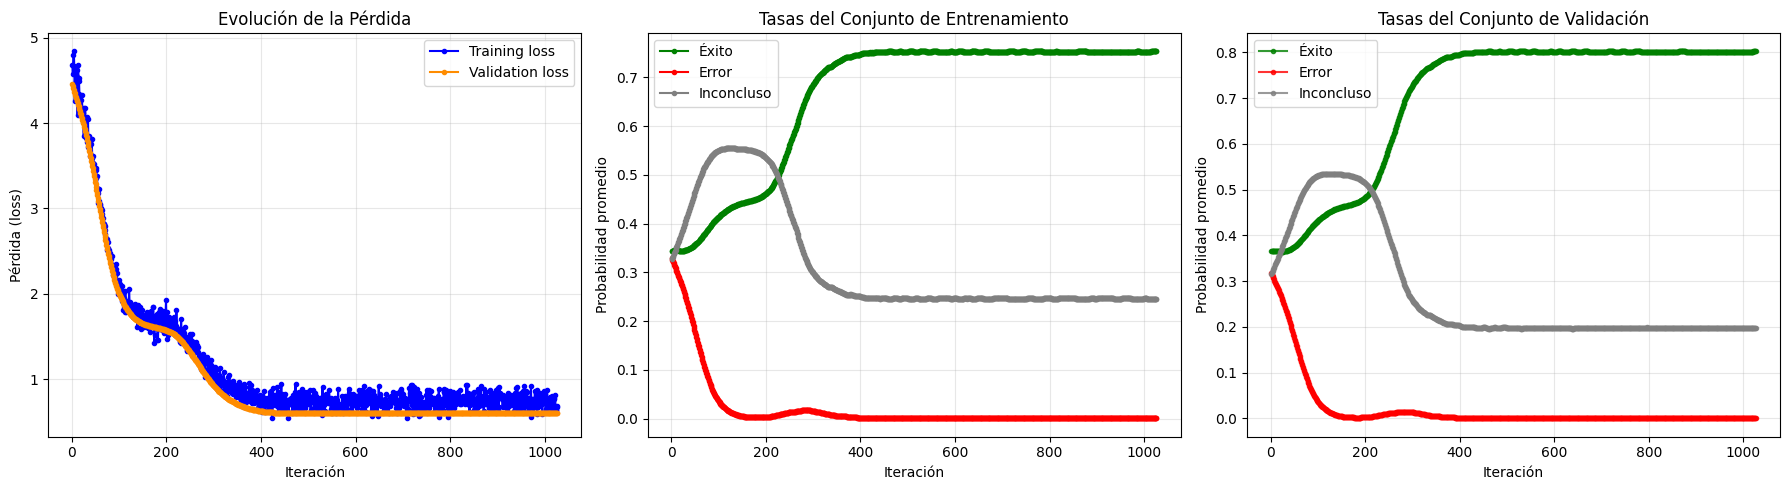

In [13]:
it = len(train_suc_history)

# Visualización de los resultados
plt.figure(figsize=(18, 5))

# 1. Evolución de la pérdida
plt.subplot(1, 3, 1)
plt.plot(range(1, it+1), loss_history, '.-', label="Training loss", color='blue')
plt.plot(range(1, it+1), val_loss_history, '.-', label="Validation loss", color='darkorange')
plt.xlabel("Iteración")
plt.ylabel("Pérdida (loss)")
plt.title("Evolución de la Pérdida")
plt.grid(True, alpha=0.3)
plt.legend()

# 2. Tasas en entrenamiento
plt.subplot(1, 3, 2)
plt.plot(range(1, it+1), train_suc_history, '.-', label="Éxito", color='green')
plt.plot(range(1, it+1), train_err_history, '.-', label="Error", color='red')
plt.plot(range(1, it+1), train_inc_history, '.-', label="Inconcluso", color='gray')
plt.xlabel("Iteración")
plt.ylabel("Probabilidad promedio")
plt.title("Tasas del Conjunto de Entrenamiento")
plt.grid(True, alpha=0.3)
plt.legend()

# 3. Tasas en validación
plt.subplot(1, 3, 3)
plt.plot(range(1, it+1), val_suc_history, '.-', label="Éxito", color='green', alpha=0.8)
plt.plot(range(1, it+1), val_err_history, '.-', label="Error", color='red', alpha=0.8)
plt.plot(range(1, it+1), val_inc_history, '.-', label="Inconcluso", color='gray', alpha=0.8)
plt.xlabel("Iteración")
plt.ylabel("Probabilidad promedio")
plt.title("Tasas del Conjunto de Validación")
plt.grid(True, alpha=0.3)
plt.legend()

plt.tight_layout()
plt.show()

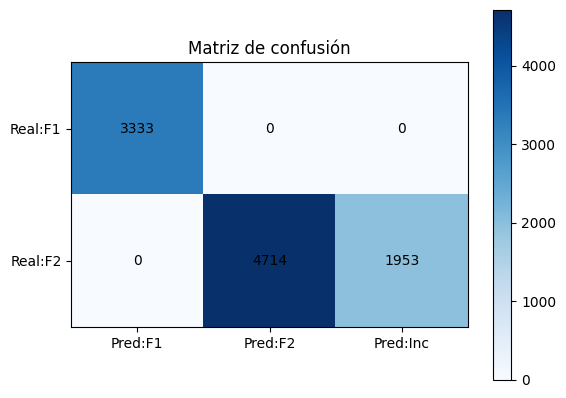

In [14]:
#Matriz de confusión

def predict_label(params, val, actual_label):
    """
    Devuelve la predicción discreta:
      1 => familia 1
      2 => familia 2
      3 => inconcluso


    actual_label se usa para saber qué outcome corresponde a éxito o error.
    """
    probs = get_probabilities(params, val, actual_label)

    p_fam1 = probs[0] + probs[2]
    p_fam2 = probs[1]
    p_inc  = probs[3]

    # Tomamos la mayor de las tres
    idx = np.argmax([p_fam1, p_fam2, p_inc])
    predicted = [1, 2, 3][idx]  # 1=fam1, 2=fam2, 3=inconcluso
    return predicted

def confusion_matrix_inconclusive(params, samples):

    cm = np.zeros((2, 3))
    for (val, actual_label) in samples:
        pred = predict_label(params, val, actual_label)
        row = actual_label - 1  # (1->0, 2->1)
        col = pred - 1          # (1->0, 2->1, 3->2)
        cm[row, col] += 1
    return cm

def plot_confusion_matrix_inconclusive(cm, normalize=False):
    """
    Dibuja la matriz
    """
    cm_display = cm.copy()
    if normalize:
        for i in range(cm_display.shape[0]):
            row_sum = np.sum(cm_display[i, :])
            if row_sum > 0:
                cm_display[i, :] /= row_sum


    fig, ax = plt.subplots()
    im = ax.imshow(cm_display, cmap='Blues', origin='upper')

    # Etiquetas de ejes
    ax.set_xticks([0,1,2])
    ax.set_yticks([0,1])
    ax.set_xticklabels(["Pred:F1","Pred:F2","Pred:Inc"])
    ax.set_yticklabels(["Real:F1","Real:F2"])

    # Texto en cada celda
    for i in range(2):
        for j in range(3):
            val = cm_display[i, j]
            if normalize:
                txt = f"{val*100:.1f}%"
            else:
                txt = f"{val:.0f}"
            ax.text(j, i, txt, ha='center', va='center', color='black')

    plt.colorbar(im, ax=ax)
    plt.title("Matriz de confusión")
    plt.show()


cm_test = confusion_matrix_inconclusive(params, data_test)
plot_confusion_matrix_inconclusive(cm_test, normalize=False)
